# Analyzing Road Traffic Collisions in Canada

 <div class="alert alert-block alert-info">
    <b> Enhancing Road Safety through Comprehensive Data Analysis of the National Collision Database of Canada</b>
 </div>

# Read the data into Pandas dataframe and clean up dates:

First, we start by importing all of the packages that will be needed for the analysis:

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import calendar
sns.set(rc={'figure.figsize':(14.7,11.27)})
plt.style.use('seaborn')
title_fontsize = 20 
axis_fontsize = 14
palette = {'1': 'tab:green',
    '2': 'tab:orange',
    '3': 'tab:red'}
import warnings
warnings.filterwarnings("ignore")

By reading the data using pandas, we can see that some cleanup of the data is needed. To simplify the analysis, let's remove all observations where an unknown value is recorded on any variables.

In [2]:
ncdb = pd.read_csv("2019_dataset_en.csv")

In [3]:
# Check the data type for each column and the number of observations we are dealing with
print(ncdb.shape)
print(ncdb.dtypes)

(272301, 23)
C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS     int64
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
dtype: object


In [4]:
ncdb.head(5)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,2019,1,1,11,2,2,32,1,1,5,...,1,2015,1,M,56,QQ,1,2,U,2681651
1,2019,1,1,11,2,2,32,1,1,5,...,1,2015,UU,U,UU,UU,U,UU,U,2681651
2,2019,1,1,11,2,2,32,1,1,5,...,1,2010,1,F,30,11,2,2,1,2681651
3,2019,1,1,11,2,2,32,1,1,5,...,1,2010,2,U,1,QQ,N,NN,U,2681651
4,2019,1,1,16,2,2,32,1,2,5,...,1,2007,1,F,27,11,2,2,1,2681652


Clean up the data and remove all rows where an "unknown" is recorded

In [5]:
print(ncdb["C_MNTH"].unique())
print(ncdb["C_WDAY"].unique())
print(ncdb["C_HOUR"].unique())

[1 2 3 4 5 6 7 8 9 10 11 12 '12' 'UU']
[1 2 3 4 5 6 7 '4' '5' '6' '7' 'U']
['11' '16' '20' '21' '12' '14' '22' '17' '9' '13' '10' '18' '19' '7' '6'
 '8' '15' '4' '5' '0' '3' '23' '1' '2' 'UU']


In [6]:
# Remove all observations where month/day/hour is unknown

ncdb = ncdb[~(ncdb["C_HOUR"] == "UU") &
    ~(ncdb["C_WDAY"] == "U") &
    ~(ncdb["C_MNTH"] == "UU")]

In [7]:
# Verify transformations in exported file
# ncdb.to_csv(r'ncdb_out.csv')

In [8]:
# Convert the first 4 variables ("C_YEAR","C_MNTH","C_WDAY","C_HOUR") to datetime
# Convert the columns to strings first and add leading zeroes to months/dates/hour with length of 1

for col in ["C_YEAR","C_MNTH","C_WDAY","C_HOUR"]:
    ncdb[col] = ncdb[col].astype(str)
    ncdb[col] = ncdb[col].str.zfill(2)

# Then convert to datetime using pandas, add as a new column, and set it as the index

ncdb["date_time"] = ncdb[["C_YEAR","C_MNTH","C_WDAY","C_HOUR"]].agg("-".join,axis=1)
ncdb["date_time"] = pd.to_datetime(ncdb["date_time"],format="%Y-%m-%d-%H")
ncdb_ts = ncdb.set_index("date_time")

In [9]:
# Verify transformations in exported file
# ncdb_ts.to_csv(r'ncdb_out1.csv')

# Determine the frequency of collisions on a specific hour/day/month:

In [10]:
list(calendar.month_name[1:])

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


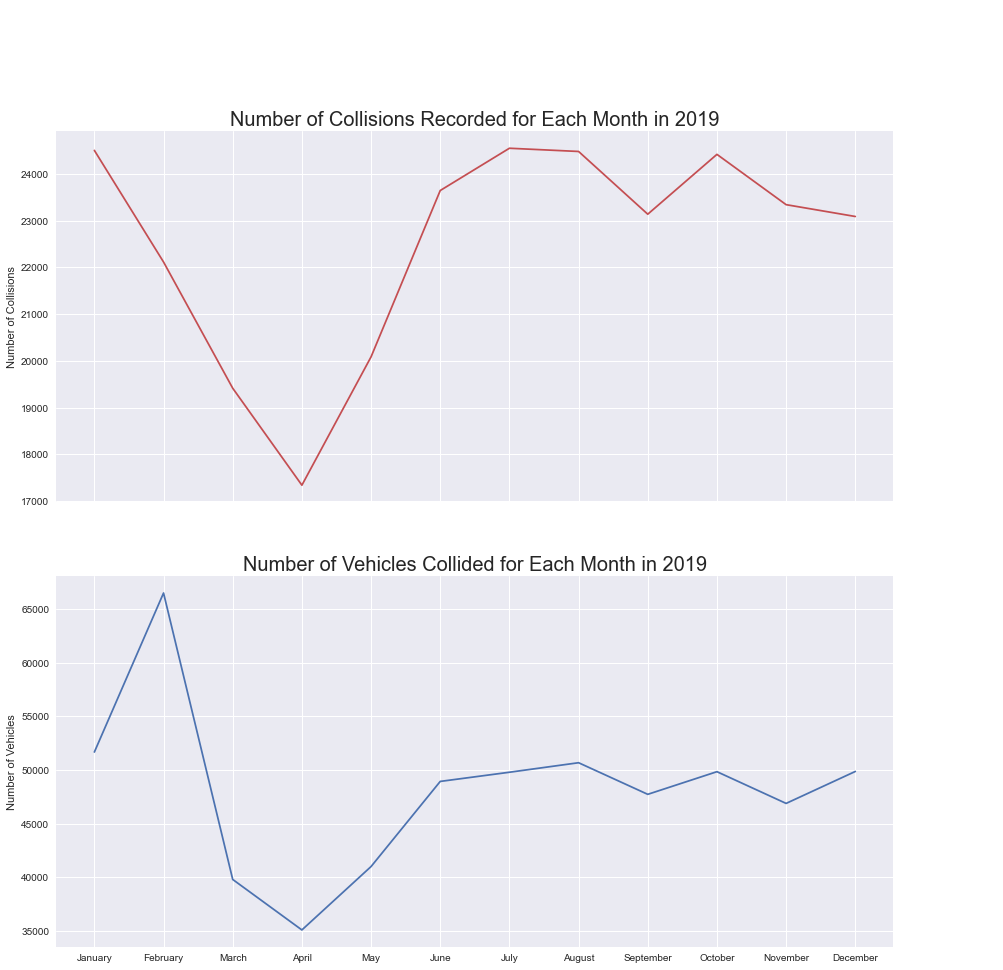

In [11]:
# Find out how many collisions happened for each month by resampling the ncdb_ts dataframe using time series
# Data dictionary for C_SEV: 1 is collision with at least one fatality, 2 is collision without any fatality

no_casualty_mnthly = ncdb_ts[ncdb_ts["C_SEV"] == 2]["C_SEV"].resample('M').count()
casualty_mnthly = ncdb_ts[ncdb_ts["C_SEV"] == 1]["C_SEV"].resample('M').count() + no_casualty_mnthly

# Find out how many vehicles collided for each month by resampling the ncdb_ts dataframe using time series
# C_VEHS is the number of vehicles involved in each collision

vehicles_mnthly = ncdb_ts["C_VEHS"].resample('M').sum()

# Plot them out with months as the x axis

mth_col = list(calendar.month_name[1:])

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

fig.set_figheight(15)
fig.set_figwidth(15)

ax1.plot(mth_col, casualty_mnthly, color='r')
ax1.set_ylabel("Number of Collisions")
ax1.set_title("Number of Collisions Recorded for Each Month in 2019",fontdict={'fontsize': title_fontsize})

ax2.plot(mth_col, vehicles_mnthly, color='b')
ax2.set_ylabel("Number of Vehicles")
ax2.set_title("Number of Vehicles Collided for Each Month in 2019",fontdict={'fontsize': title_fontsize})

fig.legend()

plt.show()

'''Conclusions:
- April has the least number of collisions recorded
- Winter was thought to have a higher number but we don't see a significant increase 
- In general the number of collisions is level with the exception of Mar - May
- Spring has a smaller number of vehicles involved in a collision
- Feb has more vehicles involved in a collision than other months, i.e. 3 compared to 2'''

In [12]:
# Look at average vehicles recorded in a collision for each month

vehicles_mnthly / casualty_mnthly 

date_time
2019-01-31    2.108459
2019-02-28    3.006059
2019-03-31    2.050219
2019-04-30    2.024454
2019-05-31    2.041519
2019-06-30    2.069393
2019-07-31    2.027899
2019-08-31    2.069801
2019-09-30    2.062746
2019-10-31    2.040906
2019-11-30    2.008481
2019-12-31    2.159319
Freq: M, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


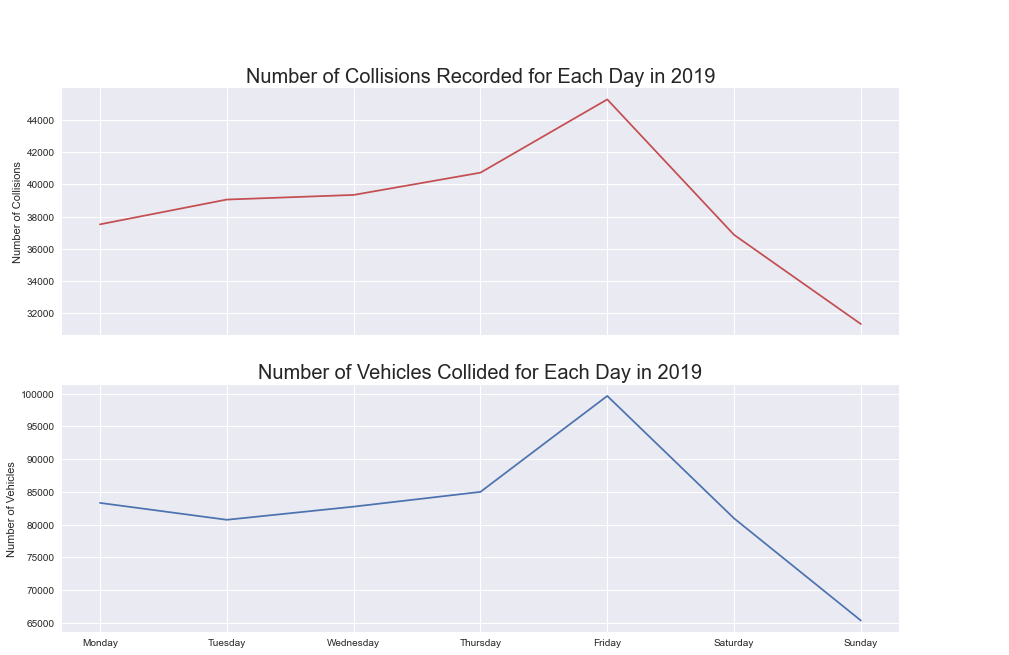

In [13]:
# Similarly, find out how many collisions happened for each day of the week by resampling the dataframe using time series
# Data dictionary for C_SEV: 1 is collision with at least one fatality, 2 is collision without any fatality

no_casualty_daily = ncdb_ts[ncdb_ts["C_SEV"] == 2].groupby(["C_WDAY"]).count()["C_SEV"]
casualty_daily = ncdb_ts[ncdb_ts["C_SEV"] == 1].groupby(["C_WDAY"]).count()["C_SEV"] + no_casualty_daily

# C_VEHS is the number of vehicles involved in each collision

vehicles_daily = ncdb_ts.groupby(["C_WDAY"]).sum()["C_VEHS"]

# Plot them out with days as the x axis

day_col = list(calendar.day_name)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

fig.set_figheight(10)
fig.set_figwidth(15)

vehicles_daily

ax1.plot(day_col,casualty_daily, color='r')
ax1.set_ylabel("Number of Collisions")
ax1.set_title("Number of Collisions Recorded for Each Day in 2019",fontdict={'fontsize': title_fontsize})

ax2.plot(day_col,vehicles_daily, color='b')
ax2.set_ylabel("Number of Vehicles")
ax2.set_title("Number of Vehicles Collided for Each Day in 2019",fontdict={'fontsize': title_fontsize})

fig.legend()

plt.show()

'''Conclusions:
- Friday had the highest number of collisions (17% higher on average)
- Sunday had the lowest (19% lower on average)'''

In [14]:
# How much bigger/smaller the number of collisions for Fridays and Sundays

print(casualty_daily["05"]/casualty_daily.mean() - 1)
print(casualty_daily["07"]/casualty_daily.mean() - 1)

0.1730409032019249
-0.18790671848972795


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


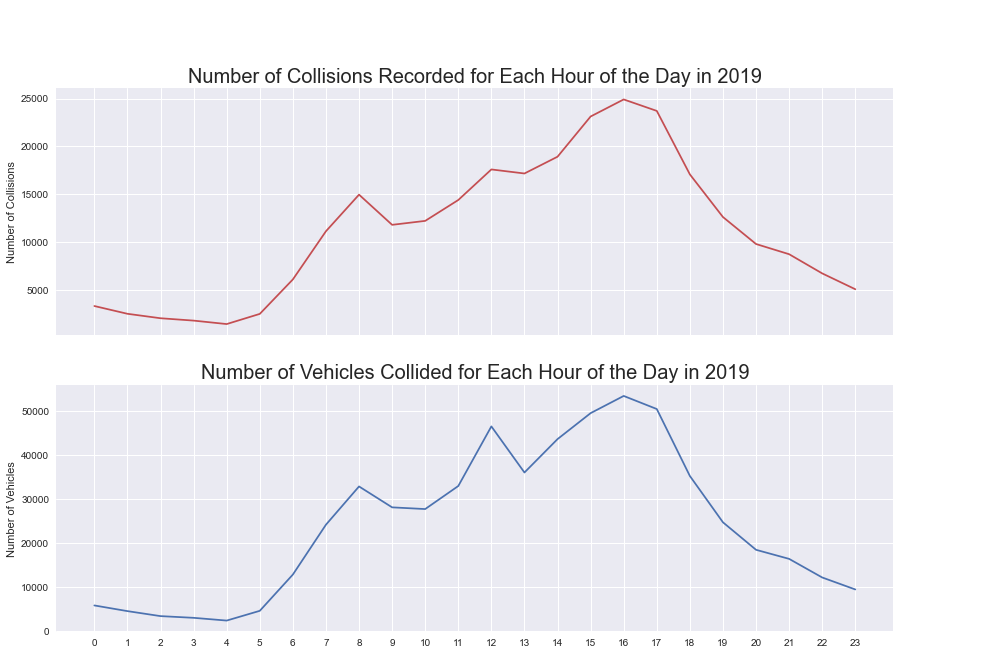

In [15]:
# Similarly, find out how many collisions happened for each hour of the day by resampling the dataframe using time series
# Data dictionary for C_SEV: 1 is collision with at least one fatality, 2 is collision without any fatality

no_casualty_hourly = ncdb_ts[ncdb_ts["C_SEV"] == 2].groupby(["C_HOUR"]).count()["C_SEV"]
casualty_hourly = ncdb_ts[ncdb_ts["C_SEV"] == 1].groupby(["C_HOUR"]).count()["C_SEV"] + no_casualty_hourly

# C_VEHS is the number of vehicles involved in each collision

vehicles_hourly = ncdb_ts.groupby(["C_HOUR"]).sum()["C_VEHS"]

# Plot them out with days as the x axis

hourly_col = list(range(0,24))

no_casualty_hourly

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

fig.set_figheight(10)
fig.set_figwidth(15)

vehicles_daily

ax1.plot(hourly_col, casualty_hourly, color='r')
ax1.set_ylabel("Number of Collisions")
ax1.set_title("Number of Collisions Recorded for Each Hour of the Day in 2019",fontdict={'fontsize': title_fontsize})
plt.xticks(np.arange(24))

ax2.plot(hourly_col, vehicles_hourly, color='b')
ax2.set_ylabel("Number of Vehicles")
ax2.set_title("Number of Vehicles Collided for Each Hour of the Day in 2019",fontdict={'fontsize': title_fontsize})

fig.legend()

plt.show()

'''Conclusions:
- peak is at 4 pm, valley is at 4 am'''

# Continue to clean up data and engineer new features to simplify the analysis:

Let's clean up the other columns.

In [16]:
print(ncdb_ts.shape)
print(ncdb_ts.dtypes)

(270150, 23)
C_YEAR    object
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS     int64
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
dtype: object


In [17]:
# Get the unique values from each column we will clean

print(ncdb_ts["C_RCFG"].unique())
print(ncdb_ts["C_WTHR"].unique())
print(ncdb_ts["C_RSUR"].unique())
print(ncdb_ts["C_CONF"].unique())
print(ncdb_ts["C_RALN"].unique())
print(ncdb_ts["C_TRAF"].unique())
print(ncdb_ts["V_YEAR"].unique())
print(ncdb_ts["V_TYPE"].unique())
print(ncdb_ts["P_SAFE"].unique())
print(ncdb_ts["P_ISEV"].unique())
print(ncdb_ts["P_AGE"].unique())
print(ncdb_ts["P_SEX"].unique())
print(ncdb_ts["P_USER"].unique())

['1' '2' 'UU' '7' '3' '4' 'QQ' '5' '6' '8' '9' '10']
['1' '2' '7' '4' '3' '5' '6' 'U' 'Q']
['5' '2' '1' '4' '3' 'U' 'Q' '6' '7' '9' '8']
['32' '4' '2' '33' '5' '3' '35' '24' '21' '22' '1' '31' 'QQ' '23' '41'
 '34' '6' '36' 'UU' '25']
['4' '3' '1' 'U' '2' '5' '6' 'Q']
['18' '12' '1' 'UU' '4' '6' '3' '13' 'QQ' '2' '8' '9' '17' '15' '16' '11'
 '5' '10' '7']
['2015' '2010' '2007' '2009' '2011' 'NNNN' '2006' '2014' 'UUUU' '2013'
 '2012' '2002' '2008' '2003' '2016' '2001' '2004' '1997' '2005' '1998'
 '1992' '1996' '2017' '2018' '1999' '2019' '2000' '1989' '1994' '1995'
 '1993' '1987' '1970' '1991' '1990' '1988' '1978' '1979' '1986' '1976'
 '1982' '1985' '1980' '1981' '1983' '1984' '2020' '1974' '1975' '1958'
 '1967' '1969' '1973' '1966' '1965' '1954' '1963' '1968' '1951' '1972'
 '1938' '1947' '1977' '1957' '1971' '1955' '1962' '1950' '1960' '1927'
 '1964' '1956' '1920' '1918' '1959']
['1' 'NN' '7' '5' '8' '6' 'QQ' '11' '20' '9' 'UU' '22' '17' '21' '14' '16'
 '19' '23' '18' '10']
['2' 'UU' 'N

In [18]:
# Remove all unknown observations from aforementioned columns

ncdb_ts = ncdb_ts[~ncdb_ts["C_RCFG"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["C_WTHR"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["C_RSUR"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["C_CONF"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["C_RALN"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["C_TRAF"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["V_YEAR"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["V_TYPE"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["P_SAFE"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["P_ISEV"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~ncdb_ts["P_AGE"].str.contains("[a-zA-Z]").fillna(False)]
ncdb_ts = ncdb_ts[~(ncdb_ts["P_SEX"] == "U")]
ncdb_ts = ncdb_ts[~ncdb_ts["P_USER"].str.contains("[a-zA-Z]").fillna(False)]

In [19]:
# Verify unique values in columns

print(ncdb_ts["C_RCFG"].unique())
print(ncdb_ts["C_WTHR"].unique())
print(ncdb_ts["C_RSUR"].unique())
print(ncdb_ts["C_CONF"].unique())
print(ncdb_ts["C_RALN"].unique())
print(ncdb_ts["C_TRAF"].unique())
print(ncdb_ts["V_YEAR"].unique())
print(ncdb_ts["V_TYPE"].unique())
print(ncdb_ts["P_SAFE"].unique())
print(ncdb_ts["P_ISEV"].unique())
print(ncdb_ts["P_AGE"].unique())
print(ncdb_ts["P_SEX"].unique())
print(ncdb_ts["P_USER"].unique())

['1' '2' '3' '4' '5' '8' '6' '9' '10' '7']
['1' '2' '4' '3' '6' '7' '5']
['5' '2' '3' '1' '4' '6' '7' '9' '8']
['32' '4' '2' '33' '35' '3' '21' '24' '22' '1' '23' '31' '41' '34' '5' '6'
 '36' '25']
['4' '3' '1' '2' '5' '6']
['18' '12' '1' '4' '6' '3' '13' '2' '8' '9' '17' '15' '11' '5' '16' '10'
 '7']
['2010' '2007' '2009' '2011' '2006' '2014' '2012' '2008' '2003' '2002'
 '2015' '2016' '2013' '1997' '2004' '2005' '2017' '2018' '1999' '2000'
 '2019' '1989' '1998' '2001' '1996' '1995' '1987' '1991' '1990' '1988'
 '1994' '1992' '1993' '1986' '1976' '1982' '1985' '1980' '1981' '2020'
 '1975' '1978' '1967' '1983' '1984' '1973' '1965' '1963' '1979' '1966'
 '1968' '1951' '1972' '1938' '1969' '1947' '1974' '1977' '1971' '1955'
 '1962' '1950' '1960' '1927' '1956' '1970' '1920' '1964']
['1' '5' '6' '7' '9' '8' '11' '17' '21' '14' '23' '10' '18']
['2' '1' '13' '12' '9']
['2' '1' '3']
['30' '27' '5' '18' '38' '23' '49' '64' '36' '35' '56' '1' '20' '44' '66'
 '21' '19' '28' '46' '69' '22' '48' '26'

In [20]:
# Verify transformations in exported file
# ncdb.to_csv(r'ncdb_out2.csv')

In [21]:
# Assigning 1's to a new total_collisions column so we can easily aggregate in visualizations

ncdb_ts['total_collisions'] = '1'

In [22]:
# Change data types to integers

for col in ["P_AGE","P_SAFE","C_CONF","C_TRAF","V_YEAR","C_RCFG","C_RALN","C_WTHR","C_RSUR","P_USER","C_MNTH","C_WDAY","total_collisions"]:
    ncdb_ts[col] = ncdb_ts[col].astype(int)

In [23]:
# Check max and min for P_AGE to create bins

ncdb_ts['P_AGE'].agg(['min', 'max'])

min     1
max    99
Name: P_AGE, dtype: int64

In [24]:
# Create a new feature P_AGERANGE based on the variable P_AGE - it is easier to look at a range of ages instead of individual ages

ncdb_ts['P_AGERANGE'] = pd.cut(ncdb_ts['P_AGE'], bins=[0,17,59,100], include_lowest=True, labels=['Teen','Adult','Senior'])

In [25]:
# Check max and min for C_CONF to create bins

ncdb_ts['C_CONF'].agg(['min', 'max'])

min     1
max    41
Name: C_CONF, dtype: int64

In [26]:
# Create a new feature C_CONFRANGE based on the variable C_CONF, to simplify the type of collisions

ncdb_ts['C_CONFRANGE'] = pd.cut(ncdb_ts['C_CONF'], bins=[0,6,25,36,41], include_lowest=True, labels=['Single','Two - Same','Two - Different','Two - Parked'])

In [27]:
# Check max and min for V_YEAR to create bins

ncdb_ts['V_YEAR'].agg(['min', 'max'])

min    1920
max    2020
Name: V_YEAR, dtype: int64

In [28]:
# Create a new feature V_YEARRANGE based on the variable V_YEAR, similar reasoning to age

ncdb_ts['V_YEARRANGE'] = pd.cut(ncdb_ts['V_YEAR'], bins=[1920, 1980, 1990, 2000, 2010, 2020], include_lowest=True, 
                                labels=['<1980','1981-1990','1991-2000','2001-2010','2011-2020'])

# Plot the distribution of collisions for each variable:

<AxesSubplot:xlabel='P_USER', ylabel='count'>

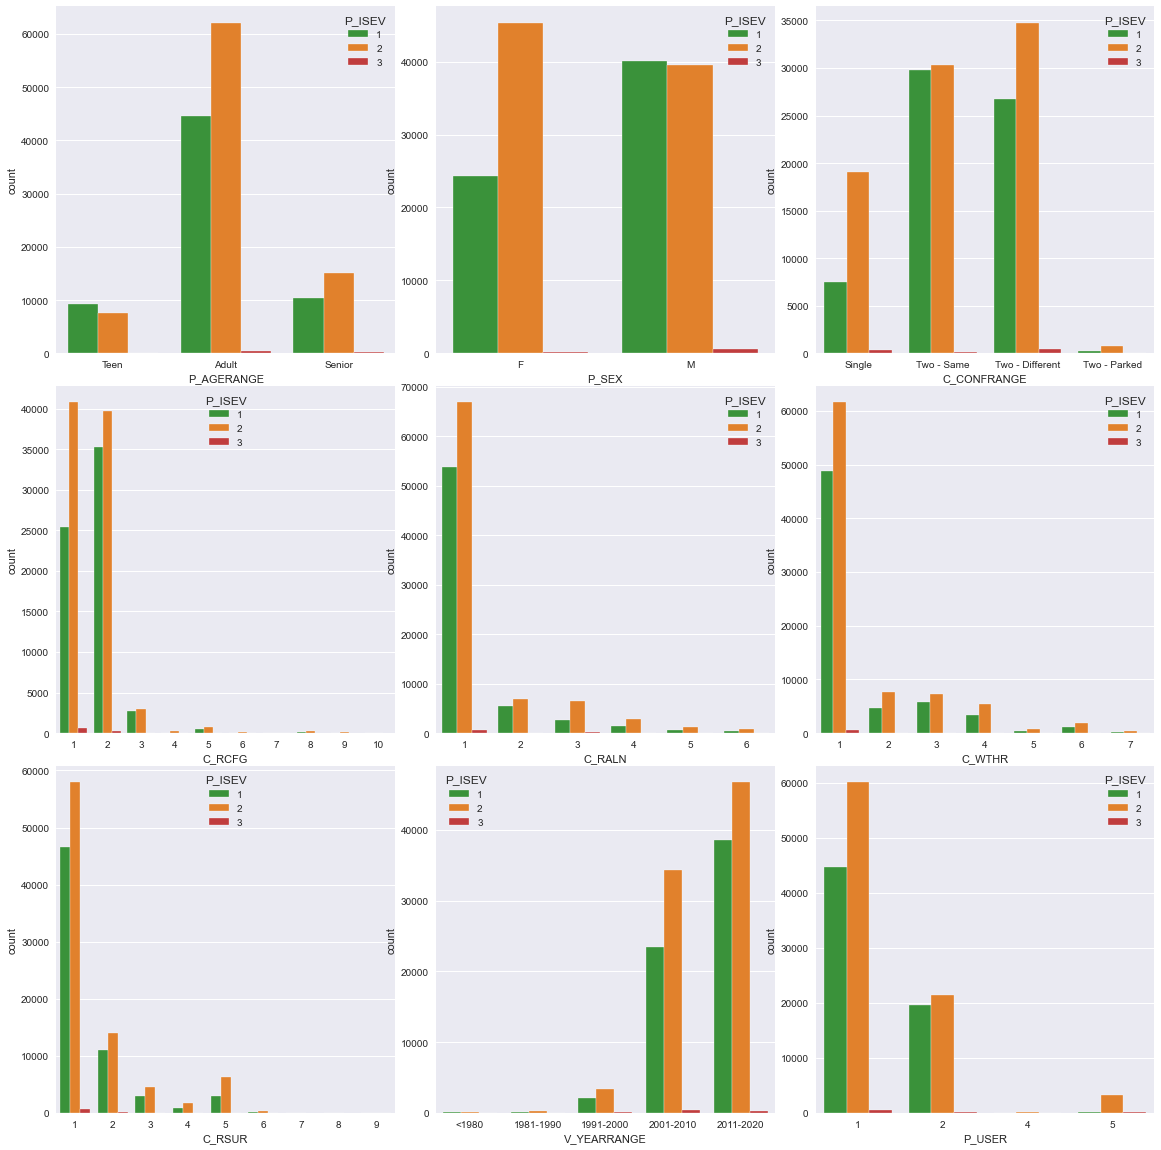

In [29]:
# Create subplots for the variables we processed earlier

fig, ax = plt.subplots(3, 3, figsize=(16,16))
plt.tight_layout()

sns.countplot(
    data=ncdb_ts,
    x='P_AGERANGE',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[0,0]
)

sns.countplot(
    data=ncdb_ts,
    x='P_SEX',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[0,1]
)

sns.countplot(
    data=ncdb_ts,
    x='C_CONFRANGE',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[0,2]
)

sns.countplot(
    data=ncdb_ts,
    x='C_RCFG',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[1,0]
)

sns.countplot(
    data=ncdb_ts,
    x='C_RALN',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[1,1]
)

sns.countplot(
    data=ncdb_ts,
    x='C_WTHR',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[1,2]
)

sns.countplot(
    data=ncdb_ts,
    x='C_RSUR',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[2,0]
)

sns.countplot(
    data=ncdb_ts,
    x='V_YEARRANGE',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[2,1]
)

sns.countplot(
    data=ncdb_ts,
    x='P_USER',
    hue='P_ISEV',
    hue_order=['1','2','3'],
    palette= palette,
    ax=ax[2,2]
)

'''Conclusions:
- R_RCFG: collisions more likely to happen at non intersections and intersections of at least 2 public roadways
- C_RALN: collisions happening on surfaces that are straight and level
- C_WTHR: ''clear and sunny
- R_SURF: ''dry and normal
- P_USER: ''motor vehicle drivers and passengers'''

# Analyze the number and severity of collisions in certain weather conditions:

([<matplotlib.axis.XTick at 0x233d6bcbcd0>,
 [Text(0, 0, 'Sunny'),
  Text(1, 0, 'Overcast'),
  Text(2, 0, 'Rain'),
  Text(3, 0, 'Snow'),
  Text(4, 0, 'Freezing Rain'),
  Text(5, 0, 'Lim Vis'),
  Text(6, 0, 'Wind')])

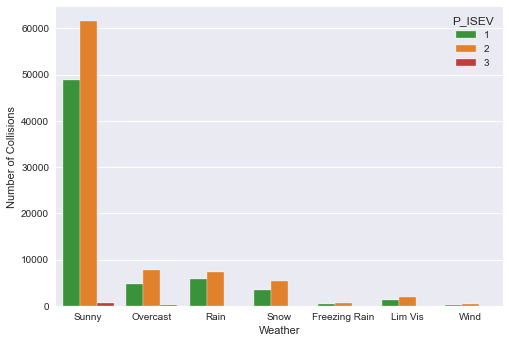

In [30]:
# Plot the number of accidents happening in certain weather conditions

sns.countplot(data=ncdb_ts, 
            x="C_WTHR", 
            hue='P_ISEV', 
            palette= palette,
            hue_order=['1','2','3'],)

# Set x-axis label
plt.xlabel('Weather')
# Set y-axis label
plt.ylabel('Number of Collisions')
plt.xticks(np.arange(7),['Sunny', 'Overcast', 'Rain',"Snow","Freezing Rain", "Lim Vis","Wind"])


In [31]:
# Percentage of collisions happning on Sunny days

ncdb_ts.groupby(["C_WTHR"])["C_WTHR"].count() / ncdb_ts["C_WTHR"].count()

# 73.9% for sunny, followed by 8.7% on overcasts and 8.3% for on rainy days

C_WTHR
1    0.739115
2    0.082726
3    0.087594
4    0.059400
5    0.007220
6    0.020788
7    0.003157
Name: C_WTHR, dtype: float64

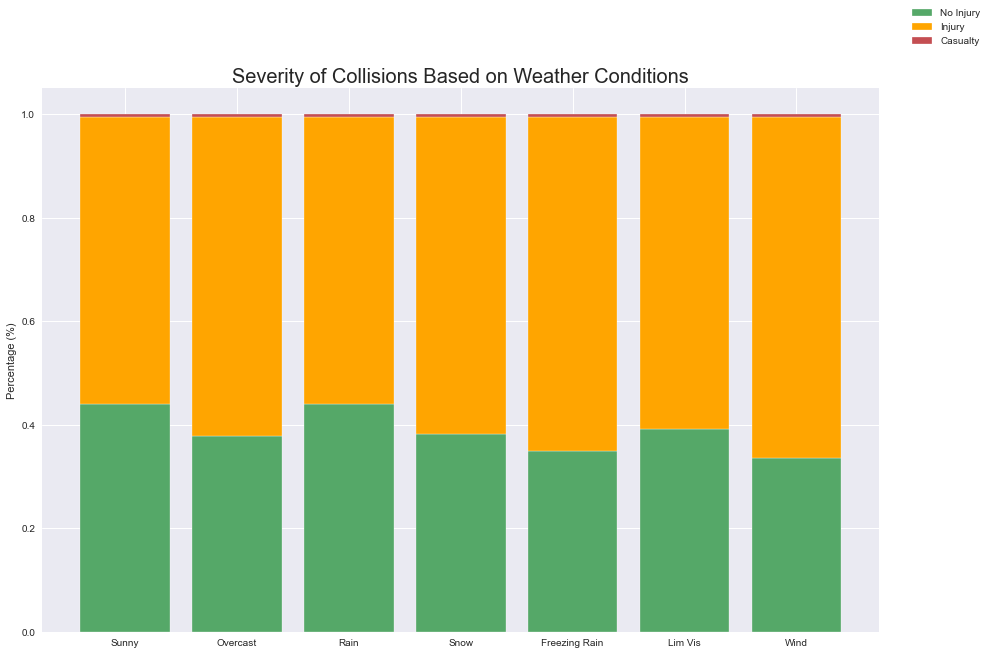

In [32]:
# Get the percentage of severity for each weather condition

weathers = ncdb_ts.groupby(["P_ISEV","C_WTHR"], as_index=False)["total_collisions"].count()

total_cols = ncdb_ts.groupby(["C_WTHR"], as_index=False)["total_collisions"].count()

total_cols_extended = pd.concat([total_cols,total_cols,total_cols],ignore_index=True)
    
weathers["percentage"] = weathers["total_collisions"] / total_cols_extended["total_collisions"]

# Plot a stacked bar graph using the percentages 

fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

wthr_labels = ['Sunny', 'Overcast', 'Rain',"Snow","Freezing Rain", "Lim Vis","Wind"]

bot_value = weathers[weathers["P_ISEV"] == '1']['percentage'].to_numpy() + weathers[weathers["P_ISEV"] == '2']['percentage'].to_numpy()

ax1.bar(x = wthr_labels, height = weathers[weathers["P_ISEV"] == '1']['percentage'], color='g', label='No Injury')
ax1.bar(x = wthr_labels, height = weathers[weathers["P_ISEV"] == '2']['percentage'], color='orange', label='Injury', bottom = weathers[weathers["P_ISEV"] == '1']['percentage'])
ax1.bar(x = wthr_labels, height = weathers[weathers["P_ISEV"] == '3']['percentage'], color='r', label='Casualty', bottom = bot_value)
ax1.set_ylabel("Percentage (%)")
ax1.set_title("Severity of Collisions Based on Weather Conditions",fontdict={'fontsize': title_fontsize})

fig.legend()

'''Conclusions:
- Casualty is constant
- Freezing rain and wind results more likely in injury
- Sunny and rainy results less likely in injury'''

# Analyze the number and severity of collisions based on vehicle age:

([<matplotlib.axis.XTick at 0x233d6ced370>,
 [Text(0, 0, '<1980'),
  Text(1, 0, '1981-1990'),
  Text(2, 0, '1991-2000'),
  Text(3, 0, '2001-2010'),
  Text(4, 0, '2011-2020')])

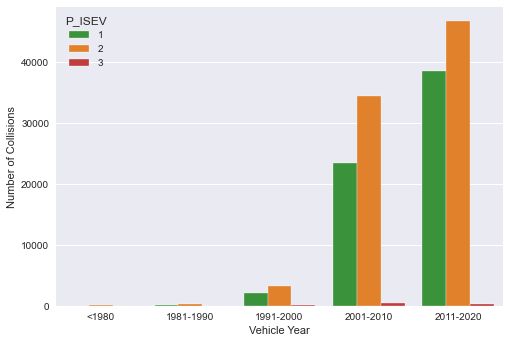

In [33]:
# Plot the number of accidents for vehicle ages
sns.countplot(data=ncdb_ts, 
            x="V_YEARRANGE", 
            hue='P_ISEV', 
            palette= palette,
            hue_order=['1','2','3'],)

# Set x-axis label
plt.xlabel('Vehicle Year')
# Set y-axis label
plt.ylabel('Number of Collisions')
plt.xticks(np.arange(5),['<1980','1981-1990','1991-2000','2001-2010','2011-2020'])


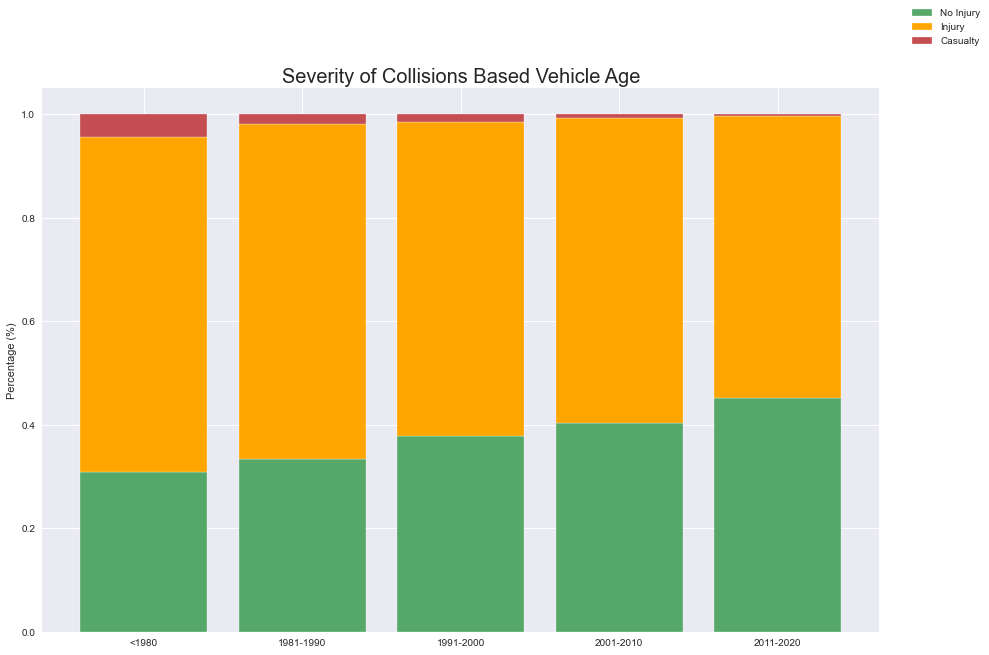

In [34]:
# Get the percentage of severity for each vehicle age bin

v_age = ncdb_ts.groupby(["P_ISEV","V_YEARRANGE"], as_index=False)["total_collisions"].count()

total_cols = ncdb_ts.groupby(["V_YEARRANGE"], as_index=False)["total_collisions"].count()

total_cols_extended = pd.concat([total_cols,total_cols,total_cols],ignore_index=True)
    
v_age["percentage"] = v_age["total_collisions"] / total_cols_extended["total_collisions"]

# Plot a stacked bar graph using the percentages 

fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

v_age_labels = ['<1980','1981-1990','1991-2000','2001-2010','2011-2020']

bot_value = v_age[v_age["P_ISEV"] == '1']['percentage'].to_numpy() + v_age[v_age["P_ISEV"] == '2']['percentage'].to_numpy()

ax1.bar(x = v_age_labels, height = v_age[v_age["P_ISEV"] == '1']['percentage'], color='g', label='No Injury')
ax1.bar(x = v_age_labels, height = v_age[v_age["P_ISEV"] == '2']['percentage'], color='orange', label='Injury', bottom = v_age[v_age["P_ISEV"] == '1']['percentage'])
ax1.bar(x = v_age_labels, height = v_age[v_age["P_ISEV"] == '3']['percentage'], color='r', label='Casualty', bottom = bot_value)
ax1.set_ylabel("Percentage (%)")
ax1.set_title("Severity of Collisions Based Vehicle Age",fontdict={'fontsize': title_fontsize})

fig.legend()

In [35]:
# Find out percentage of collisions that recorded casualties ( red bars)

1- bot_value

array([0.04402516, 0.01960784, 0.01535368, 0.00761513, 0.00377882])

# Analyze the number and severity of collisions for all collision types:

([<matplotlib.axis.XTick at 0x233db01fc10>,
 [Text(0, 0, 'Single'),
  Text(1, 0, 'Two - Same'),
  Text(2, 0, 'Two - Different'),
  Text(3, 0, 'Two - Parked')])

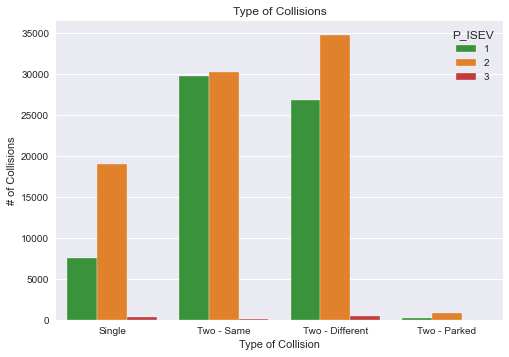

In [36]:
# Plot the number of collisions by type - one vehicle, 2 vehicles, etc

sns.countplot(data=ncdb_ts, 
            x="C_CONFRANGE", 
            hue='P_ISEV', 
            palette= palette,
            hue_order=['1','2','3'],).set(title='Type of Collisions')

# Set x-axis label
plt.xlabel("Type of Collision")
# Set y-axis label
plt.ylabel('# of Collisions')
plt.xticks(np.arange(4),['Single', 'Two - Same', 'Two - Different',"Two - Parked"])

'''Conclusions:
- 40% of all collisions were resulted from two-same
- 41% of all collisions were resulted from two-different'''

# Analyze the distribution of the severity of collisions for all collision types:

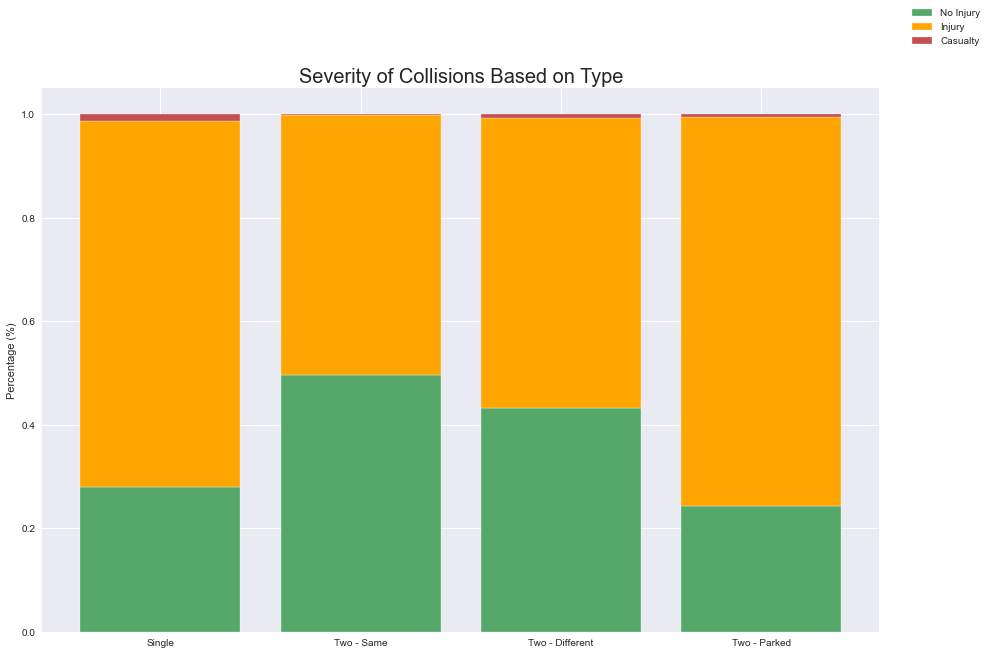

In [37]:
# Get the percentage of severity for each collision type

coltype = ncdb_ts.groupby(["P_ISEV","C_CONFRANGE"], as_index=False)["total_collisions"].count()

total_cols = ncdb_ts.groupby(["C_CONFRANGE"], as_index=False)["total_collisions"].count()

total_cols_extended = pd.concat([total_cols,total_cols,total_cols],ignore_index=True)
    
coltype["percentage"] = coltype["total_collisions"] / total_cols_extended["total_collisions"]

# Plot a stacked bar graph using the percentages 

fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

coltype_labels = ['Single', 'Two - Same', 'Two - Different',"Two - Parked"]

bot_value = coltype[coltype["P_ISEV"] == '1']['percentage'].to_numpy() + coltype[coltype["P_ISEV"] == '2']['percentage'].to_numpy()

ax1.bar(x = coltype_labels, height = coltype[coltype["P_ISEV"] == '1']['percentage'], color='g', label='No Injury')
ax1.bar(x = coltype_labels, height = coltype[coltype["P_ISEV"] == '2']['percentage'], color='orange', label='Injury', bottom = coltype[coltype["P_ISEV"] == '1']['percentage'])
ax1.bar(x = coltype_labels, height = coltype[coltype["P_ISEV"] == '3']['percentage'], color='r', label='Casualty', bottom = bot_value)
ax1.set_ylabel("Percentage (%)")
ax1.set_title("Severity of Collisions Based on Type",fontdict={'fontsize': title_fontsize})

fig.legend()

'''Conclusions:
- collisions involving a single car are more severe
- may be a bias in the data towards more disastrous collisions, ie collisions with a small animal such as raccoons or rabbits not recorded'''

In [38]:
# Percentage of collision types

coltype.groupby(["C_CONFRANGE"]).sum() / coltype["total_collisions"].sum()


,total_collisions,percentage
C_CONFRANGE,,
Single,0.179512,0.000007
Two - Same,0.400726,0.000007
Two - Different,0.412455,0.000007
Two - Parked,0.007307,0.000007


# Determine the frequency of collisions on a specific hour/day/month: (cont.)

In [39]:
# Group collisions by month and day into new dataframe

colls = ncdb_ts.groupby(["C_MNTH","C_WDAY"], as_index=False)["total_collisions"].sum()
colls

,C_MNTH,C_WDAY,total_collisions
0,1,1,1782
1,1,2,1903
2,1,3,2199
3,1,4,2324
4,1,5,1931
...,...,...,...
79,12,3,1651
80,12,4,1784
81,12,5,2146
82,12,6,1653


([<matplotlib.axis.XTick at 0x233db41e8e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

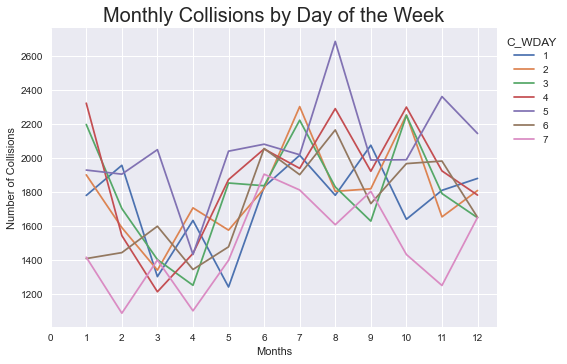

In [40]:
colls_line = sns.lineplot(data=colls, x='C_MNTH', y='total_collisions', hue='C_WDAY', palette='deep')
sns.move_legend(colls_line, "upper left", bbox_to_anchor=(1, 1))

plt.title('Monthly Collisions by Day of the Week',fontdict={'fontsize': title_fontsize})
# Set x-axis label
plt.xlabel('Months')
# Set y-axis label
plt.ylabel('Number of Collisions')
plt.xticks(np.arange(13))

# Analyze the number of collisions for different sexes across the months:

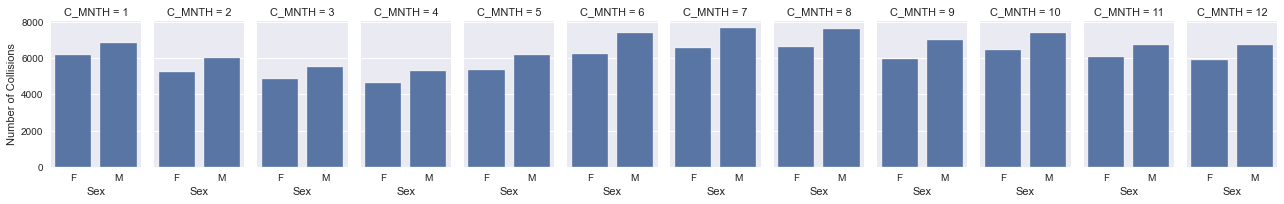

In [41]:
# Plot monthly numbers

g = sns.FacetGrid(ncdb_ts, col="C_MNTH", height=3, aspect=.5)
g.map(sns.countplot, "P_SEX", order=["F", "M"])
g.set(xlabel="Sex",ylabel="Number of Collisions")

# Analyze the distributed number and severity of collisions for different sexes across the months:

Text(0.5, 1.0, 'Monthly Collisions by Sex and Severity')

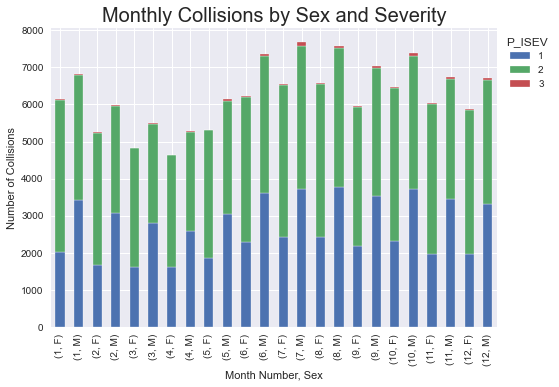

In [42]:
# Plot distribution of monthly collisions by sex and severity

colls_stack = ncdb_ts.groupby(["C_MNTH","P_SEX","P_ISEV"]).size().unstack().plot.bar(stacked=True)
sns.move_legend(colls_stack, "upper left", bbox_to_anchor=(1, 1))
colls_stack.set(xlabel="Month Number, Sex",ylabel="Number of Collisions")
plt.title('Monthly Collisions by Sex and Severity',fontdict={'fontsize': title_fontsize})

<AxesSubplot:>

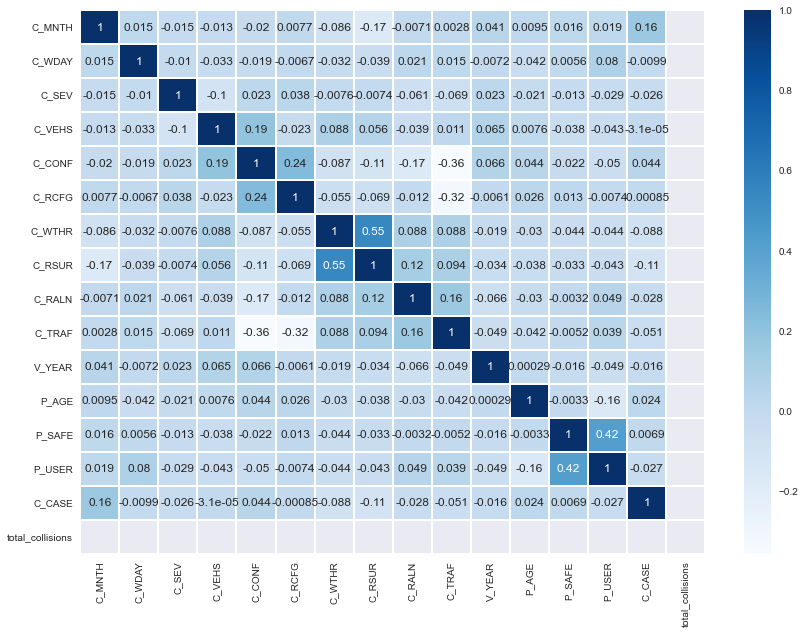

In [43]:
# Analyze the correlation of one variable vs another:

colormap = plt.cm.Blues
plt.figure(figsize=(14,10))
sns.heatmap(ncdb_ts.corr(), cmap=colormap, annot=True, linewidths=0.2)

In [44]:
# Group collisions by more variables to create new dataframe

colls1 = ncdb_ts.groupby(["C_MNTH","C_CONF","C_RCFG","C_WTHR","C_RSUR","C_RALN","C_TRAF","P_ISEV","C_SEV","P_SAFE","P_SEX","P_AGE","P_USER"], as_index=False)["total_collisions"].count()
colls1.head(20)

,C_MNTH,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,P_ISEV,C_SEV,P_SAFE,P_SEX,P_AGE,P_USER,total_collisions
0,1,1,1,1,1,1,11,2,2,12,M,24,1,1
1,1,1,1,1,1,1,18,1,2,2,M,35,1,1
2,1,1,1,1,1,1,18,2,2,2,F,19,1,1
3,1,1,1,1,1,1,18,2,2,2,F,19,2,1
4,1,1,1,1,1,1,18,2,2,2,F,26,1,1
5,1,1,1,1,1,1,18,2,2,2,F,31,1,1
6,1,1,1,1,1,1,18,2,2,2,F,43,2,1
7,1,1,1,1,1,1,18,2,2,2,F,47,1,2
8,1,1,1,1,1,1,18,2,2,2,F,54,1,1
9,1,1,1,1,1,1,18,2,2,2,F,56,1,3


# Analyze collision location

Text(0.5, 1.0, 'Total Collisions and Severity based on Collision Location')

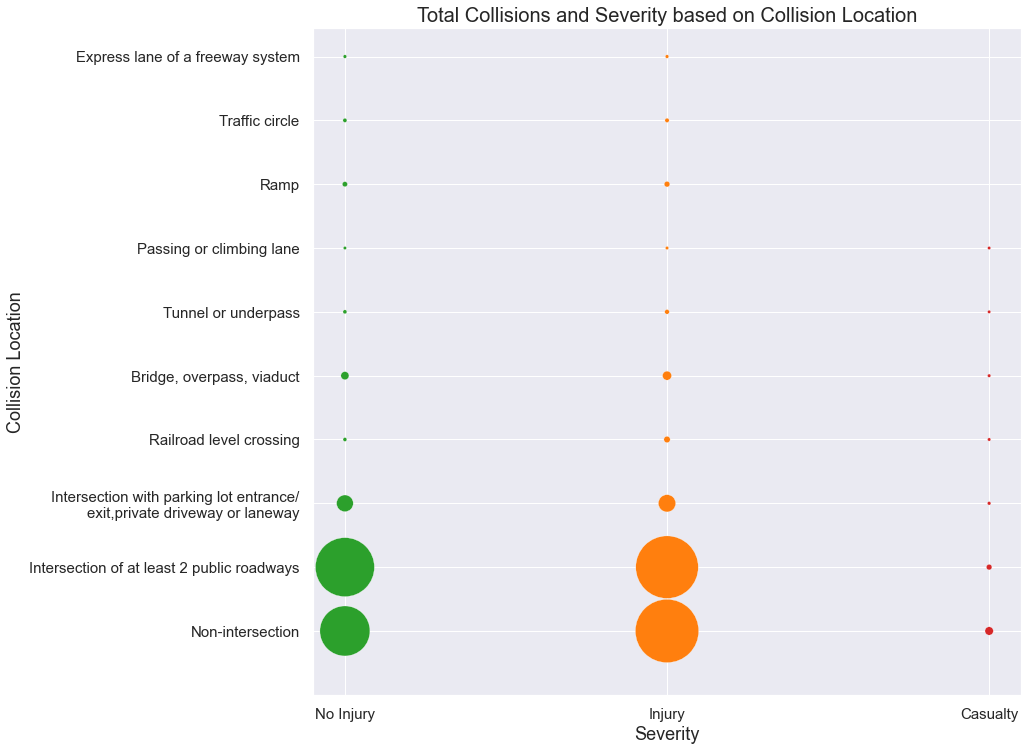

In [45]:
# Analyze Severity based on collision location

sns.set(rc={'figure.figsize':(12.7,12.27)})

colls_data1 = ncdb_ts.groupby(["P_ISEV","C_RCFG"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data1, x="P_ISEV", y="C_RCFG" ,size="total_collisions", legend=False,
                sizes=(10, 4000), hue = "P_ISEV", palette = palette)

labels=["",'Non-intersection','Intersection of at least 2 public roadways','Intersection with parking lot entrance/\nexit,private driveway or laneway','Railroad level crossing','Bridge, overpass, viaduct','Tunnel or underpass','Passing or climbing lane','Ramp','Traffic circle','Express lane of a freeway system']

colls_road.set_yticks(range(11))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(3))
colls_road.set_xticklabels(["No Injury","Injury","Casualty"])
colls_road.set(xlabel="Severity",ylabel="Collision Location")
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=15)
colls_road.yaxis.set_tick_params(labelsize=15)
plt.title('Total Collisions and Severity based on Collision Location',fontdict={'fontsize': title_fontsize})

Text(0.5, 1.0, 'Monthly Distribution of Collision Location')

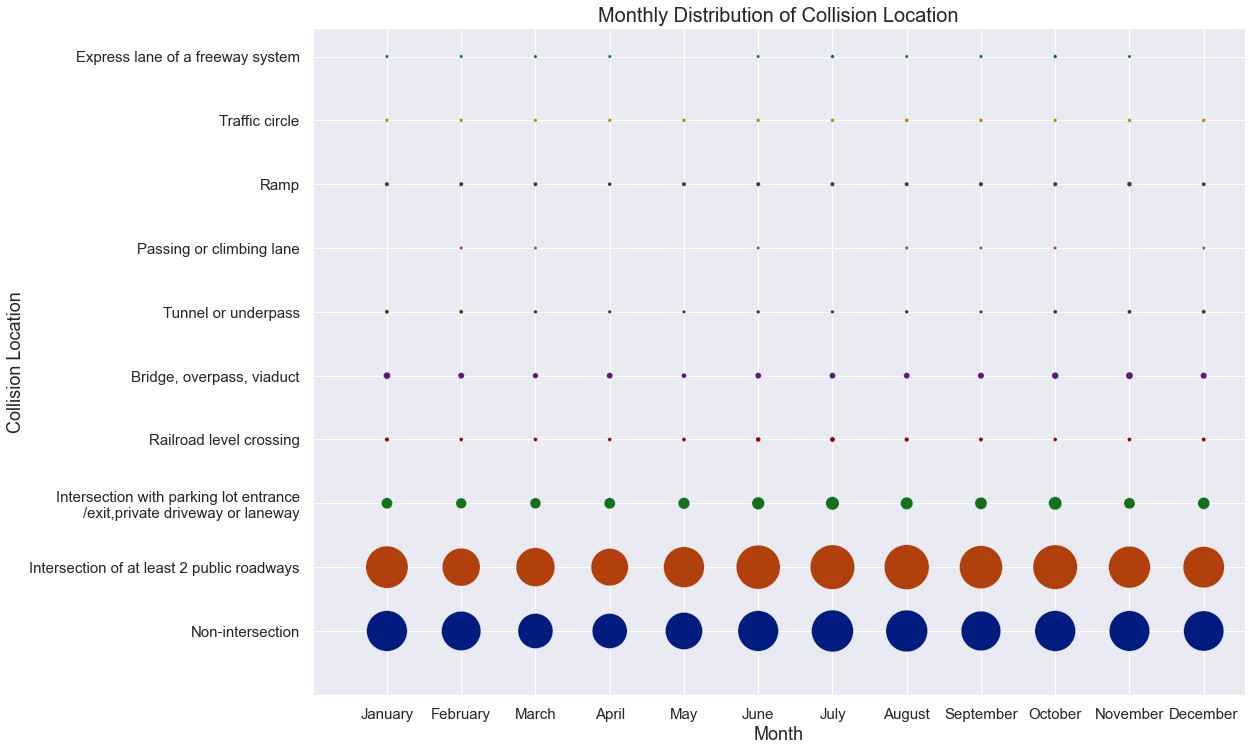

In [46]:
# Analyze collision location vs monthly

sns.set(rc={'figure.figsize':(16.7,12.27)})

colls_data2 = ncdb_ts.groupby(["C_MNTH","C_RCFG"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data2, x="C_MNTH", y="C_RCFG" ,size="total_collisions", legend=False,
                sizes=(10, 2000), hue = "C_RCFG", palette="dark")

labels=["",'Non-intersection','Intersection of at least 2 public roadways','Intersection with parking lot entrance\n/exit,private driveway or laneway','Railroad level crossing','Bridge, overpass, viaduct','Tunnel or underpass','Passing or climbing lane','Ramp','Traffic circle','Express lane of a freeway system']


colls_road.set_yticks(range(11))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(13))
colls_road.set_xticklabels([""] + mth_col)
colls_road.set(xlabel="Month",ylabel="Collision Location")
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=15)
colls_road.yaxis.set_tick_params(labelsize=15)
plt.title('Monthly Distribution of Collision Location',fontdict={'fontsize': title_fontsize})

Text(0.5, 1.0, 'Distribution of Collision Location vs Weather Condition')

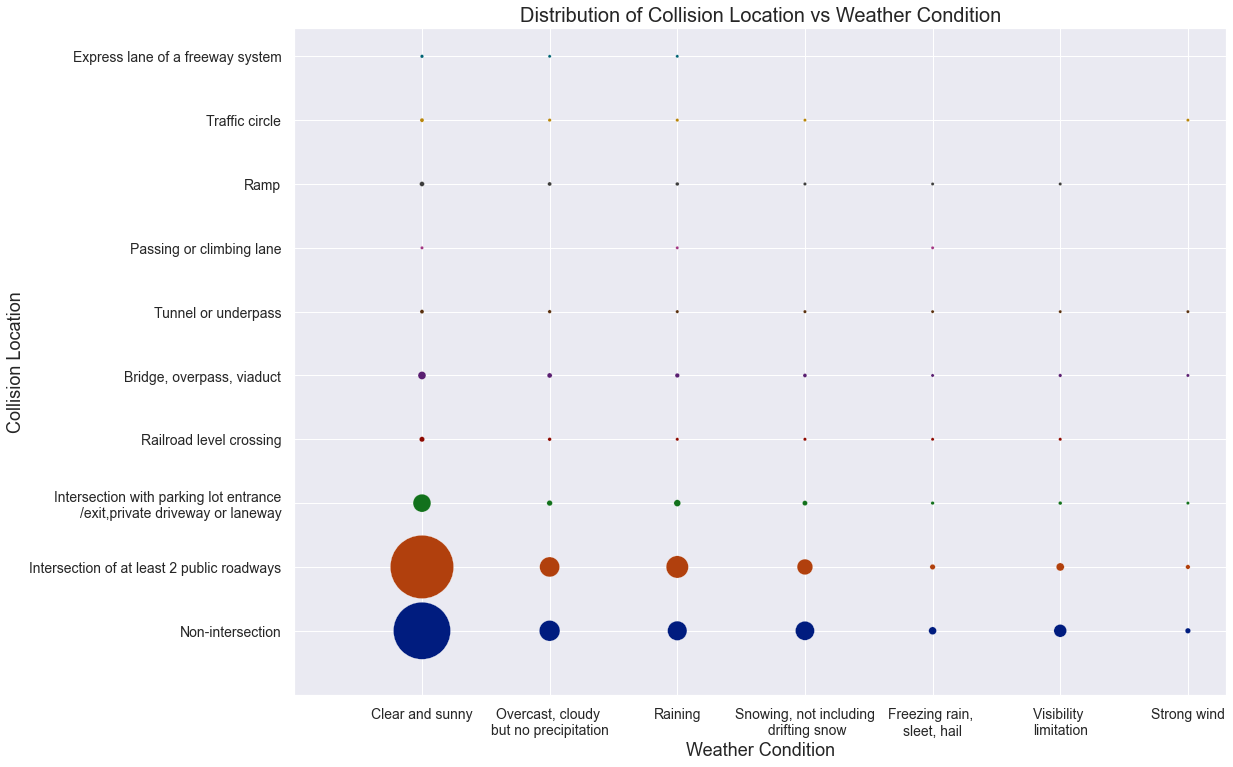

In [47]:
# Analyze collisions based on vehicle location and weather

sns.set(rc={'figure.figsize':(16.7,12.27)})

colls_data2 = ncdb_ts.groupby(["C_WTHR","C_RCFG"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data2, x="C_WTHR", y="C_RCFG" ,size="total_collisions", legend=False,
                sizes=(10, 4000), hue = "C_RCFG", palette="dark")

labels=["",'Non-intersection','Intersection of at least 2 public roadways','Intersection with parking lot entrance\n/exit,private driveway or laneway','Railroad level crossing','Bridge, overpass, viaduct','Tunnel or underpass','Passing or climbing lane','Ramp','Traffic circle','Express lane of a freeway system']

xlabels=["",'Clear and sunny','Overcast, cloudy \nbut no precipitation','Raining','Snowing, not including\n drifting snow','Freezing rain, \nsleet, hail','Visibility \nlimitation','Strong wind']

colls_road.set_yticks(range(11))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(8))
colls_road.set_xticklabels(xlabels)
colls_road.set(xlabel="Weather Condition",ylabel="Collision Location")
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=14)
colls_road.yaxis.set_tick_params(labelsize=14)
plt.title('Distribution of Collision Location vs Weather Condition',fontdict={'fontsize': title_fontsize})

# colls_bar = sns.barplot(data=colls1, x="C_RCFG", y="total_collisions", hue="C_WTHR", palette="deep", estimator = sum)
# labels=['Clear and sunny','Overcast, cloudy but no precipitation','Raining','Snowing, not including drifting snow','Freezing rain, sleet, hail','Visibility limitation','Strong wind']
# h, l = colls_bar.get_legend_handles_labels()
# colls_bar.legend(h, labels, title="Weather")
# sns.move_legend(colls_bar, "upper left", bbox_to_anchor=(1, 1))
# colls_bar.set(xlabel="Vehicle Location",ylabel="Number of Collisions")
# plt.title('Collision Distribution based on Vehicle Location and Weather',fontdict={'fontsize': title_fontsize})
# plt.xticks(range(12), ['Non-intersection','Intersection of at least 2 public roadways','Intersection with parking lot entrance/exit,private driveway or laneway','Railroad level crossing','Bridge, overpass, viaduct','Tunnel or underpass','Passing or climbing lane','Ramp','Traffic circle','Express lane of a freeway system','Collector lane of a freeway system','Transfer lane of a freeway system'])
# plt.xticks(rotation=90)

# Analyze Surface Condition

Text(0.5, 1.0, 'Distribution of Collisions Based on Road and Weather Conditions')

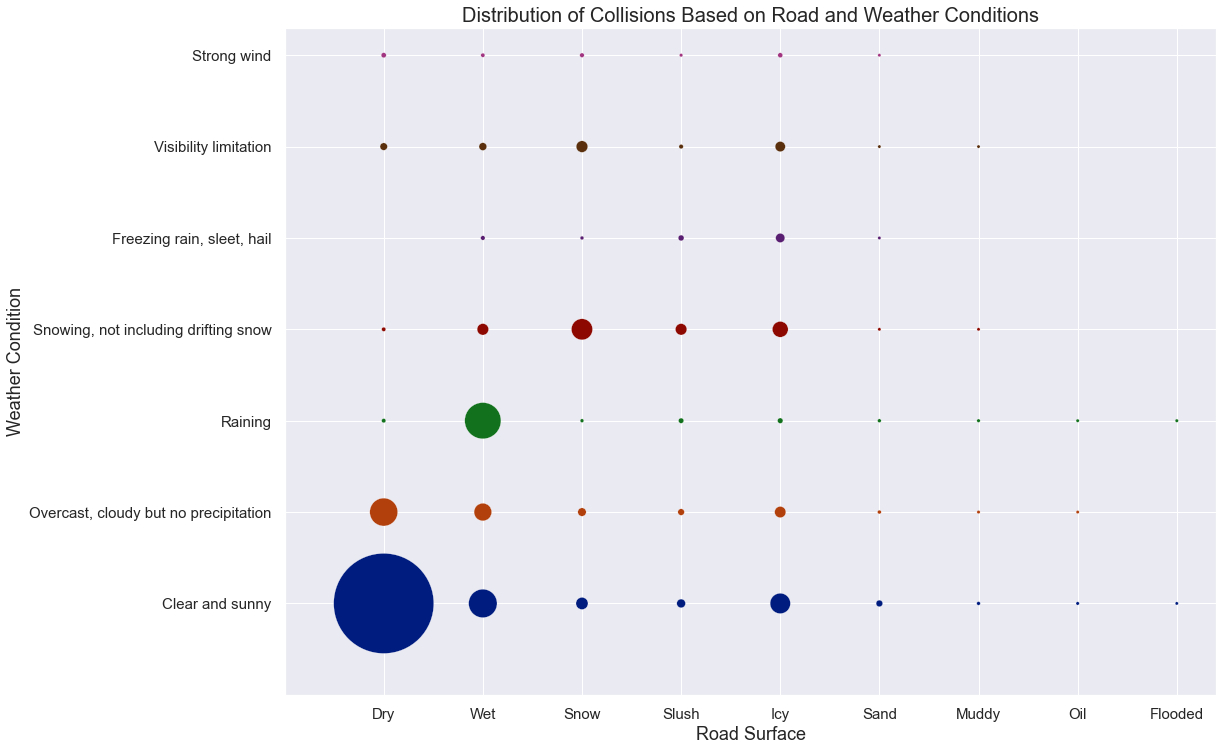

In [48]:
# Analyze collisions based on surface condition and weather

sns.set(rc={'figure.figsize':(16.7,12.27)})

colls_data3 = ncdb_ts.groupby(["C_RSUR","C_WTHR"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data3, x="C_RSUR", y="C_WTHR" ,size="total_collisions", legend=False,
                sizes=(10, 10000),hue = "C_WTHR", palette="dark")

labels=["",'Clear and sunny','Overcast, cloudy but no precipitation','Raining','Snowing, not including drifting snow','Freezing rain, sleet, hail','Visibility limitation','Strong wind']
xlabels = ["","Dry","Wet","Snow","Slush","Icy","Sand","Muddy","Oil","Flooded"]

colls_road.set_yticks(range(8))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(10))
colls_road.set_xticklabels(xlabels)
colls_road.set(xlabel="Road Surface",ylabel="Weather Condition")
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=15)
colls_road.yaxis.set_tick_params(labelsize=15)
plt.title('Distribution of Collisions Based on Road and Weather Conditions',fontdict={'fontsize': title_fontsize})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Dry'),
  Text(1, 0, 'Wet'),
  Text(2, 0, 'Snow'),
  Text(3, 0, 'Slush'),
  Text(4, 0, 'Icy'),
  Text(5, 0, 'Sand/gravel/dirt'),
  Text(6, 0, 'Muddy'),
  Text(7, 0, 'Oil'),
  Text(8, 0, 'Flooded')])

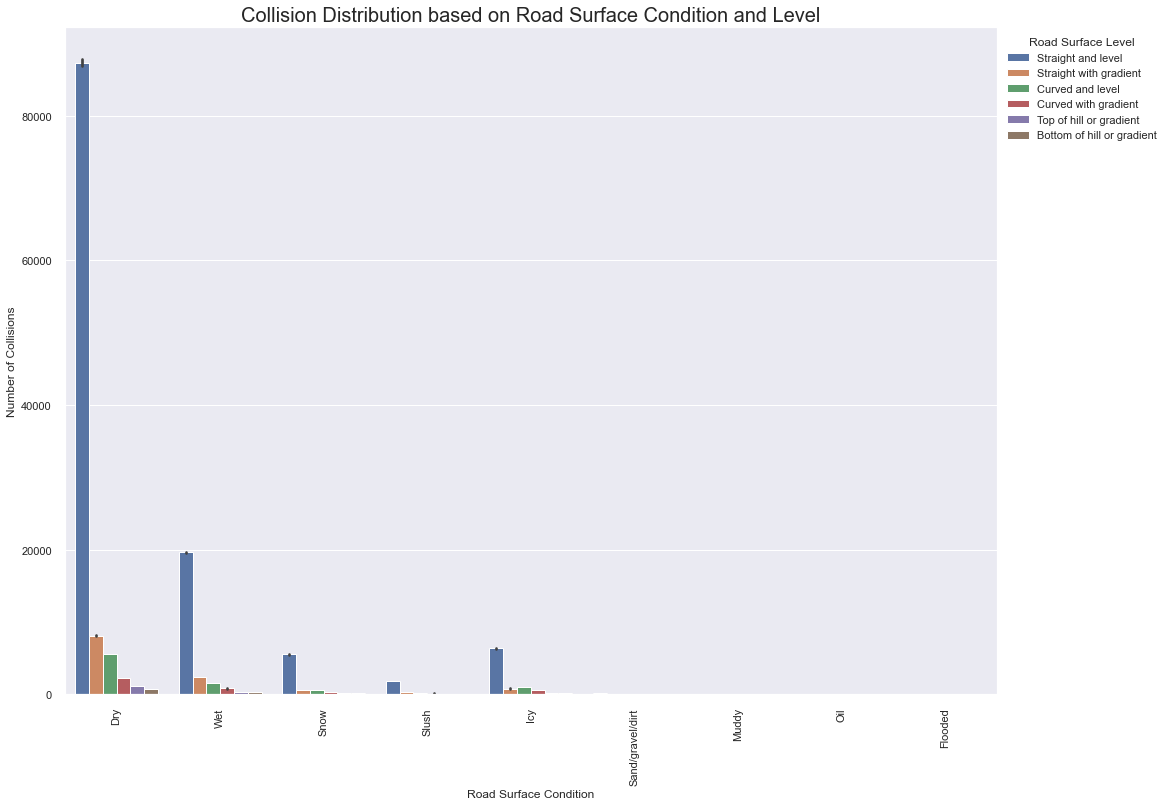

In [49]:
# Analyze collisions based on surface condition and level

colls_bar = sns.barplot(data=colls1, x="C_RSUR", y="total_collisions", hue="C_RALN", palette="deep", estimator = sum)
labels=['Straight and level','Straight with gradient','Curved and level','Curved with gradient','Top of hill or gradient','Bottom of hill or gradient']
h, l = colls_bar.get_legend_handles_labels()
colls_bar.legend(h, labels, title="Road Surface Level")
sns.move_legend(colls_bar, "upper left", bbox_to_anchor=(1, 1))
colls_bar.set(xlabel="Road Surface Condition",ylabel="Number of Collisions")
plt.title('Collision Distribution based on Road Surface Condition and Level',fontdict={'fontsize': title_fontsize})
plt.xticks(range(9), ['Dry','Wet','Snow','Slush','Icy','Sand/gravel/dirt','Muddy','Oil','Flooded'])
plt.xticks(rotation=90)

# Analyze Traffic Signs

Text(0.5, 1.0, 'Total Collisions and Severity Based on Traffic Sign')

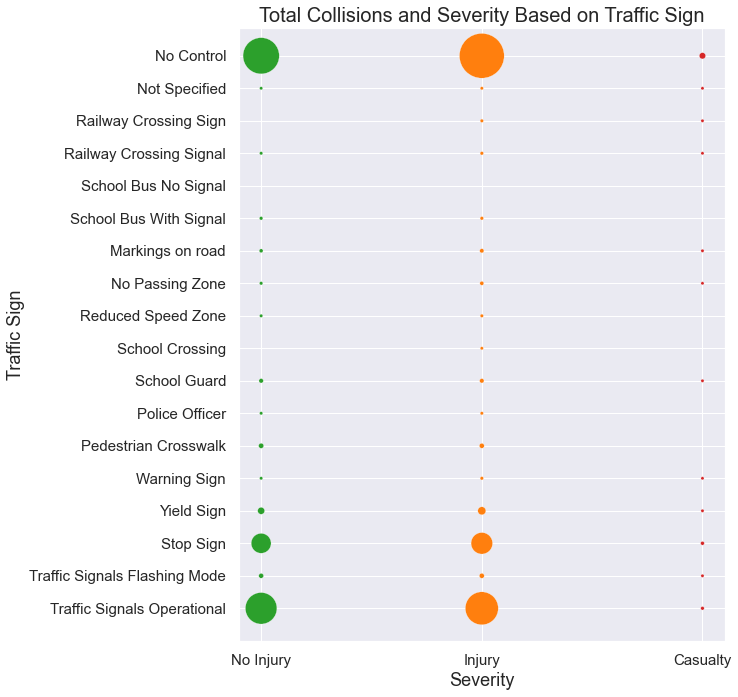

In [50]:
# Analyze severity based on traffic signs

sns.set(rc={'figure.figsize':(8.7,11.27)})

colls_data4 = ncdb_ts.groupby(["P_ISEV","C_TRAF"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data4, x="P_ISEV", y="C_TRAF" ,size="total_collisions", legend=False,
                sizes=(10, 2000), hue = "P_ISEV", palette = palette)

labels=["","Traffic Signals Operational","Traffic Signals Flashing Mode","Stop Sign","Yield Sign",
       "Warning Sign","Pedestrian Crosswalk","Police Officer","School Guard","School Crossing",
       "Reduced Speed Zone","No Passing Zone","Markings on road","School Bus With Signal","School Bus No Signal",
       "Railway Crossing Signal","Railway Crossing Sign","Not Specified","No Control"]

colls_road.set_yticks(range(19))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(3))
colls_road.set_xticklabels(["No Injury","Injury","Casualty"])
colls_road.set(xlabel="Severity",ylabel="Traffic Sign")
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=15)
colls_road.yaxis.set_tick_params(labelsize=15)
plt.title('Total Collisions and Severity Based on Traffic Sign',fontdict={'fontsize': title_fontsize})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Traffic signals fully operational'),
  Text(1, 0, 'Traffic signals in flashing mode'),
  Text(2, 0, 'Stop sign'),
  Text(3, 0, 'Yield sign'),
  Text(4, 0, 'Warning sign'),
  Text(5, 0, 'Pedestrian crosswalk'),
  Text(6, 0, 'Police officer'),
  Text(7, 0, 'School guard, flagman'),
  Text(8, 0, 'School crossing'),
  Text(9, 0, 'Reduced speed zone'),
  Text(10, 0, 'No passing zone sign'),
  Text(11, 0, 'Markings on the road'),
  Text(12, 0, 'School bus stopped with school bus signal lights flashing'),
  Text(13, 0, 'School bus stopped with school bus signal lights not flashing'),
  Text(14, 0, 'Railway corssing with signals, or signals and gates'),
  Text(15, 0, 'Railway crossing with signs only'),
  Text(16, 0, 'No control present'),
  Text(17, 0, 'Control device not specified')])

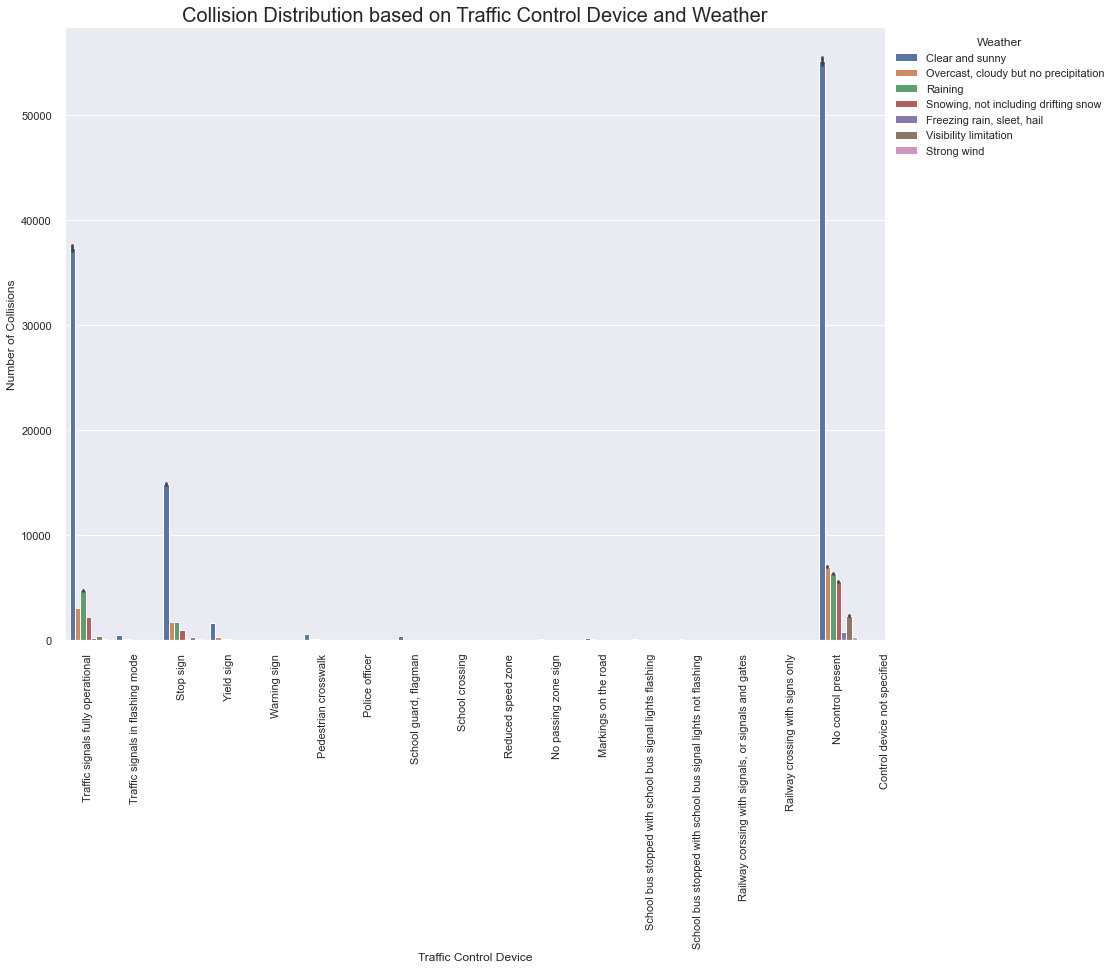

In [51]:
# Analyze collisions based on traffic control device and weather
sns.set(rc={'figure.figsize':(14.7,11.27)})
colls_bar = sns.barplot(data=colls1, x="C_TRAF", y="total_collisions", hue="C_WTHR", palette="deep", estimator = sum)
labels=['Clear and sunny','Overcast, cloudy but no precipitation','Raining','Snowing, not including drifting snow','Freezing rain, sleet, hail','Visibility limitation','Strong wind']
h, l = colls_bar.get_legend_handles_labels()
colls_bar.legend(h, labels, title="Weather")
sns.move_legend(colls_bar, "upper left", bbox_to_anchor=(1, 1))
colls_bar.set(xlabel="Traffic Control Device",ylabel="Number of Collisions")
plt.title('Collision Distribution based on Traffic Control Device and Weather',fontdict={'fontsize': title_fontsize})
plt.xticks(range(18), ['Traffic signals fully operational','Traffic signals in flashing mode','Stop sign','Yield sign','Warning sign','Pedestrian crosswalk','Police officer','School guard, flagman','School crossing','Reduced speed zone','No passing zone sign','Markings on the road','School bus stopped with school bus signal lights flashing','School bus stopped with school bus signal lights not flashing','Railway corssing with signals, or signals and gates','Railway crossing with signs only','No control present','Control device not specified'])
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Distribution of Collisions Based on Traffic Sign and Surface Level')

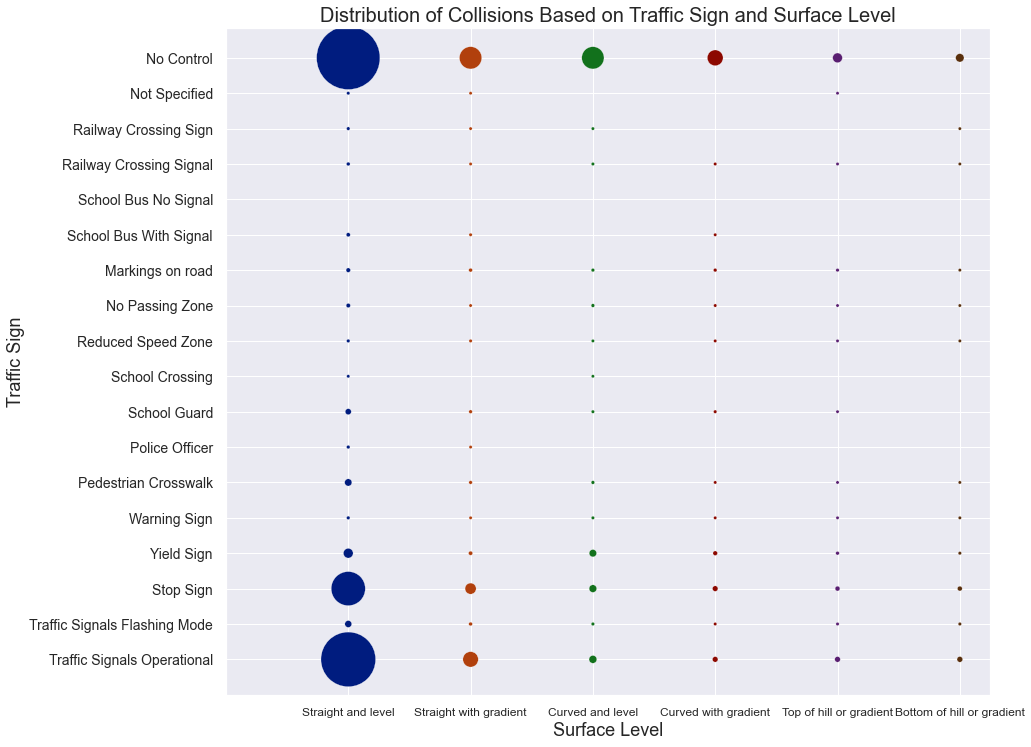

In [52]:
# Analyze based on traffic signs and surface level

sns.set(rc={'figure.figsize':(13.7,12.27)})

colls_data4 = ncdb_ts.groupby(["C_RALN","C_TRAF"], as_index=False)["total_collisions"].count()

colls_road = sns.scatterplot(data=colls_data4, x="C_RALN", y="C_TRAF" ,size="total_collisions", legend=False,
                sizes=(10, 4000), hue = "C_RALN", palette = "dark")

labels=["","Traffic Signals Operational","Traffic Signals Flashing Mode","Stop Sign","Yield Sign",
       "Warning Sign","Pedestrian Crosswalk","Police Officer","School Guard","School Crossing",
       "Reduced Speed Zone","No Passing Zone","Markings on road","School Bus With Signal","School Bus No Signal",
       "Railway Crossing Signal","Railway Crossing Sign","Not Specified","No Control"]
xlabels = ["",'Straight and level','Straight with gradient','Curved and level','Curved with gradient','Top of hill or gradient','Bottom of hill or gradient']

colls_road.set_yticks(range(19))
colls_road.set_yticklabels(labels)
colls_road.set_xticks(range(7))
colls_road.set_xticklabels(xlabels)
colls_road.xaxis.label.set(fontsize=18)
colls_road.yaxis.label.set(fontsize=18)
colls_road.xaxis.set_tick_params(labelsize=12)
colls_road.yaxis.set_tick_params(labelsize=14)
colls_road.set(xlabel="Surface Level",ylabel="Traffic Sign")
plt.title('Distribution of Collisions Based on Traffic Sign and Surface Level',fontdict={'fontsize': title_fontsize})

# Analyze vehicle configuration (cont.)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Single - Hit a moving object'),
  Text(1, 0, 'Single - Hit a stationary object'),
  Text(2, 0, 'Single - Ran off left shoulder'),
  Text(3, 0, 'Single - Ran off right shoulder'),
  Text(4, 0, 'Single - Rollover on roadway'),
  Text(5, 0, 'Single - Any other single vehicle collision config'),
  Text(6, 0, 'Two Same Direction - Rear-end collision'),
  Text(7, 0, 'Two Same Direction - Side swipe'),
  Text(8, 0, 'Two Same Direction - One passing to left of other, or left turn conflict'),
  Text(9, 0, 'Two Same Direction - one passing to right of other, or right turn conflict'),
  Text(10, 0, 'Two Same Direction - Other'),
  Text(11, 0, 'Two Different Direction - Head-on collision'),
  Text(12, 0, 'Two Different Direction - Approaching side-swipe'),
  Text(13, 0, 'Two Different Direction - Left turn across opposing traffic'),
  Text(14, 0, 'Two Different Direction - Right turn, including 

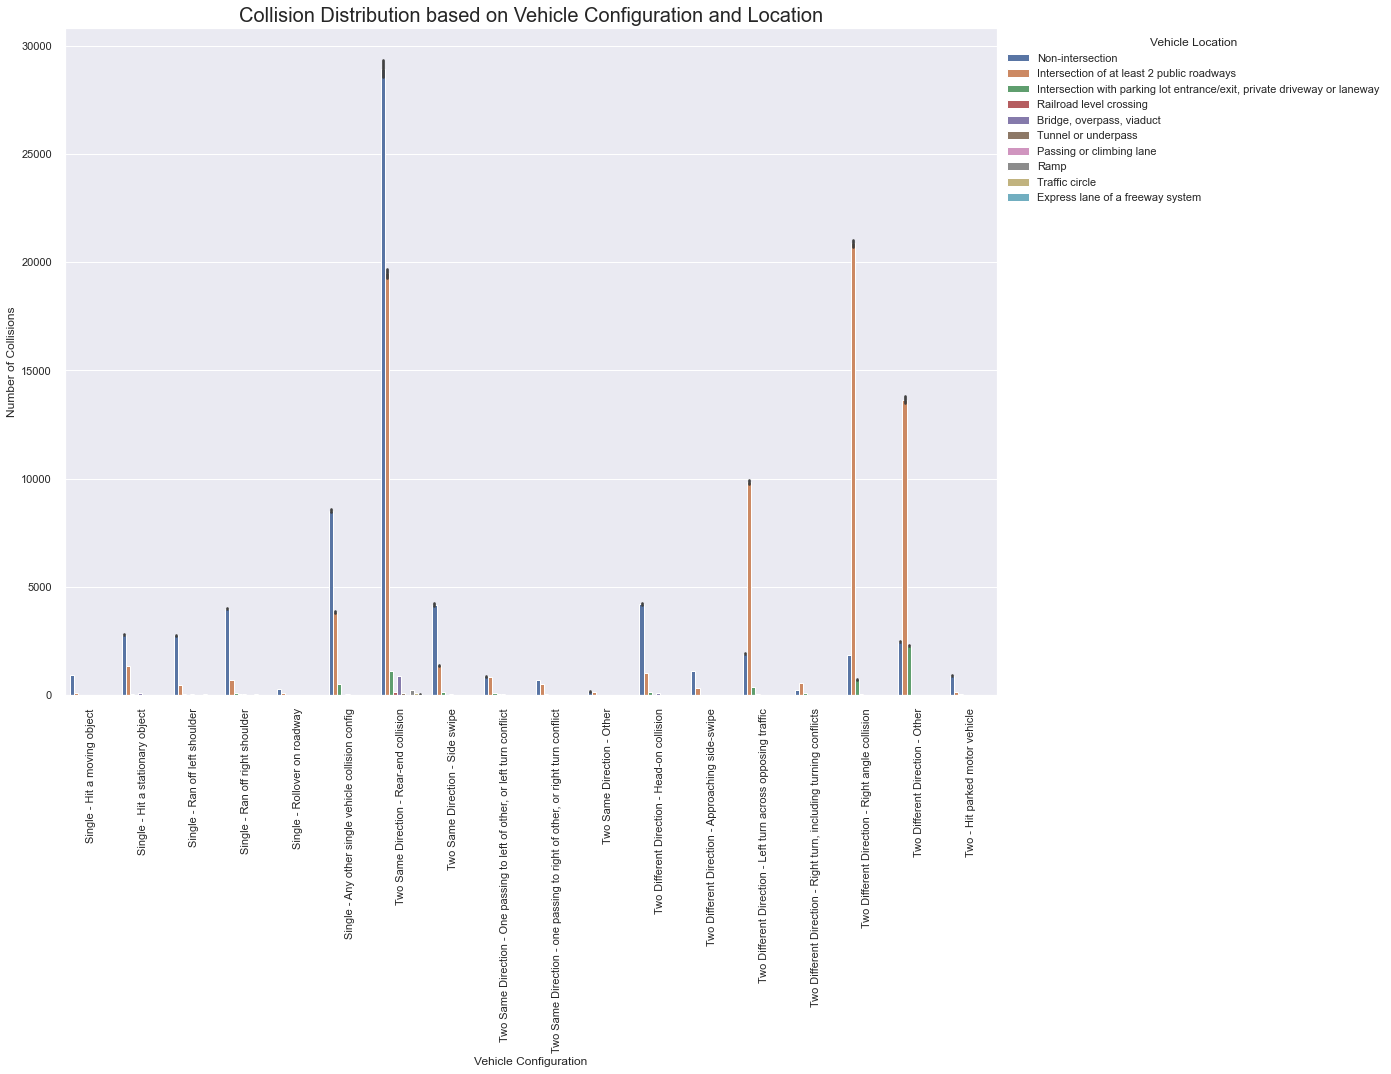

In [53]:
# Analyze collisions based on vehicle configuration and location
sns.set(rc={'figure.figsize':(16.7,12.27)})
colls_bar = sns.barplot(data=colls1, x="C_CONF", y="total_collisions", hue="C_RCFG", palette="deep", estimator = sum)
labels=['Non-intersection','Intersection of at least 2 public roadways','Intersection with parking lot entrance/exit, private driveway or laneway','Railroad level crossing','Bridge, overpass, viaduct','Tunnel or underpass','Passing or climbing lane','Ramp','Traffic circle','Express lane of a freeway system','Collector lane of a freeway system','Transfer lane of a freeway system']
h, l = colls_bar.get_legend_handles_labels()
colls_bar.legend(h, labels, title="Vehicle Location")
sns.move_legend(colls_bar, "upper left", bbox_to_anchor=(1, 1))
colls_bar.set(xlabel="Vehicle Configuration",ylabel="Number of Collisions")
plt.title('Collision Distribution based on Vehicle Configuration and Location',fontdict={'fontsize': title_fontsize})
plt.xticks(range(18), ['Single - Hit a moving object','Single - Hit a stationary object','Single - Ran off left shoulder','Single - Ran off right shoulder','Single - Rollover on roadway','Single - Any other single vehicle collision config','Two Same Direction - Rear-end collision','Two Same Direction - Side swipe','Two Same Direction - One passing to left of other, or left turn conflict','Two Same Direction - one passing to right of other, or right turn conflict','Two Same Direction - Other','Two Different Direction - Head-on collision','Two Different Direction - Approaching side-swipe','Two Different Direction - Left turn across opposing traffic','Two Different Direction - Right turn, including turning conflicts','Two Different Direction - Right angle collision','Two Different Direction - Other','Two - Hit parked motor vehicle'])
plt.xticks(rotation=90)

# Prove that using a safety device can decrease the collision severity:

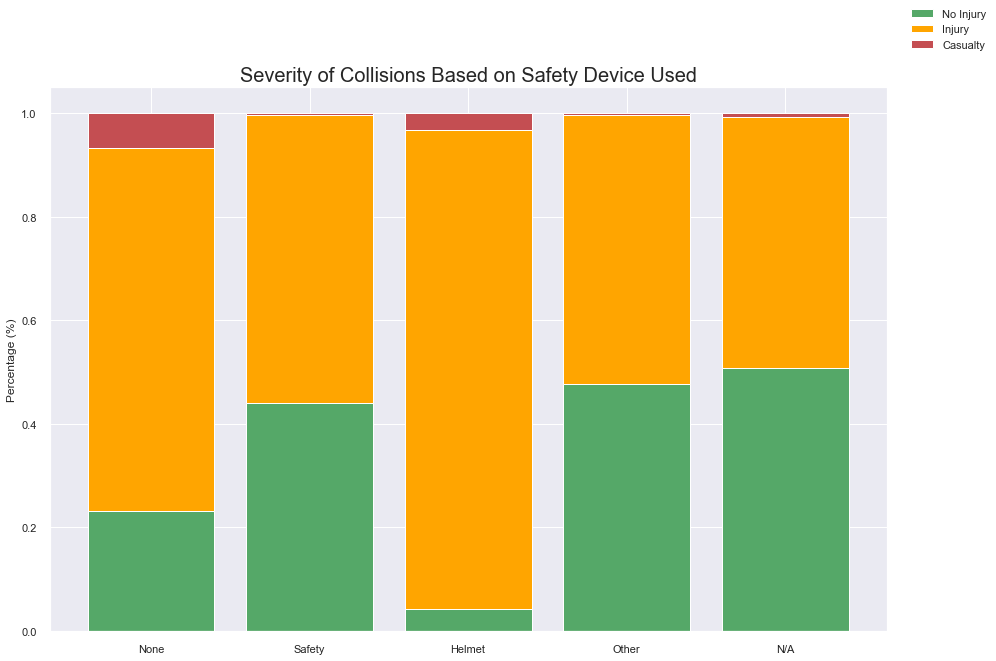

In [54]:
# Analyze how the usage of safety devices decrease the severity a collision
# Get the percentage of severity for each safety device used

colls10 = ncdb_ts.groupby(["P_ISEV","P_SAFE"], as_index=False)["total_collisions"].count()
total_cols = ncdb_ts.groupby(["P_SAFE"], as_index=False)["total_collisions"].count()

total_cols_extended = pd.concat([total_cols,total_cols,total_cols],ignore_index=True,)
    
colls10["percentage"] = colls10["total_collisions"] / total_cols_extended["total_collisions"]

# Plot a stacked bar graph using the percentages 

fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

sev_labels = ["None","Safety","Helmet","Other","N/A"]

bot_value = colls10[colls10["P_ISEV"] == '1']['percentage'].to_numpy() + colls10[colls10["P_ISEV"] == '2']['percentage'].to_numpy()

ax1.bar(x = sev_labels, height = colls10[colls10["P_ISEV"] == '1']['percentage'], color='g', label='No Injury')
ax1.bar(x = sev_labels, height = colls10[colls10["P_ISEV"] == '2']['percentage'], color='orange', label='Injury', bottom = colls10[colls10["P_ISEV"] == '1']['percentage'])
ax1.bar(x = sev_labels, height = colls10[colls10["P_ISEV"] == '3']['percentage'], color='r', label='Casualty', bottom = bot_value)
ax1.set_ylabel("Percentage (%)")
ax1.set_title("Severity of Collisions Based on Safety Device Used",fontdict={'fontsize': title_fontsize})

fig.legend()

In [55]:
# Percentage of severity based on safety device used

colls10.groupby(["P_SAFE","P_ISEV"]).sum()

total_collisions  percentage
P_SAFE P_ISEV                              
1      1                    616    0.230798
       2                   1871    0.701012
       3                    182    0.068190
2      1                  61258    0.439803
       2                  77477    0.556248
       3                    550    0.003949
9      1                    136    0.041200
       2                   3055    0.925477
       3                    110    0.033323
12     1                   1625    0.475703
       2                   1775    0.519614
       3                     16    0.004684
13     1                    743    0.507514
       2                    711    0.485656
       3                     10    0.006831

In [56]:
# Let's go further, take a look at severity for those without any safety equipment and those with
# compare against type of collision

no_safety = ncdb_ts[ncdb_ts["P_SAFE"] == 1].groupby(["P_ISEV","C_CONFRANGE"], as_index=False)["total_collisions"].count()
total_cols = ncdb_ts[ncdb_ts["P_SAFE"] == 1].groupby(["C_CONFRANGE"], as_index=False)["total_collisions"].count()
total_cols_extended = pd.concat([total_cols,total_cols,total_cols],ignore_index=True,)

no_safety["percentage"] = no_safety["total_collisions"] / total_cols_extended["total_collisions"]

safety = ncdb_ts[ncdb_ts["P_SAFE"] == 2].groupby(["P_ISEV","C_CONFRANGE"], as_index=False)["total_collisions"].count()
total_cols_sf = ncdb_ts[ncdb_ts["P_SAFE"] == 2].groupby(["C_CONFRANGE"], as_index=False)["total_collisions"].count()
total_cols_extended_sf = pd.concat([total_cols_sf,total_cols_sf,total_cols_sf],ignore_index=True,)

safety["percentage"] = safety["total_collisions"] / total_cols_extended_sf["total_collisions"]

Text(0, 0.5, 'Percentage')

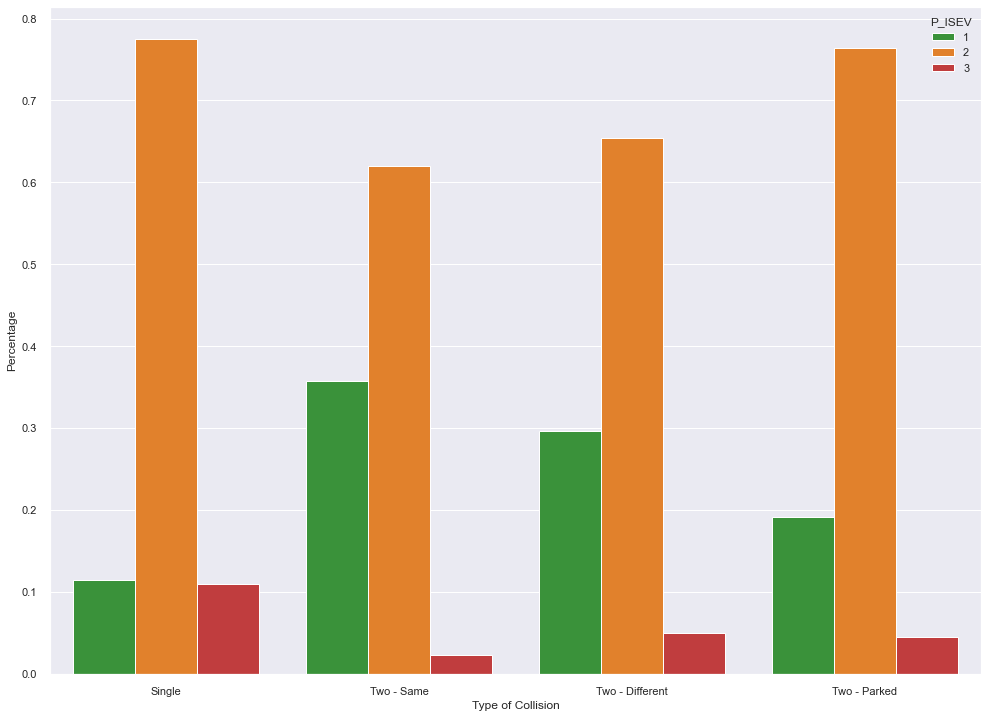

In [57]:
# plot the percentages of severity, we can see that the percentage of injury and death is higher for those without safety equipment
sns.barplot(data = no_safety, x = "C_CONFRANGE", y = "percentage", hue="P_ISEV",palette= palette,) 
plt.xlabel('Type of Collision')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

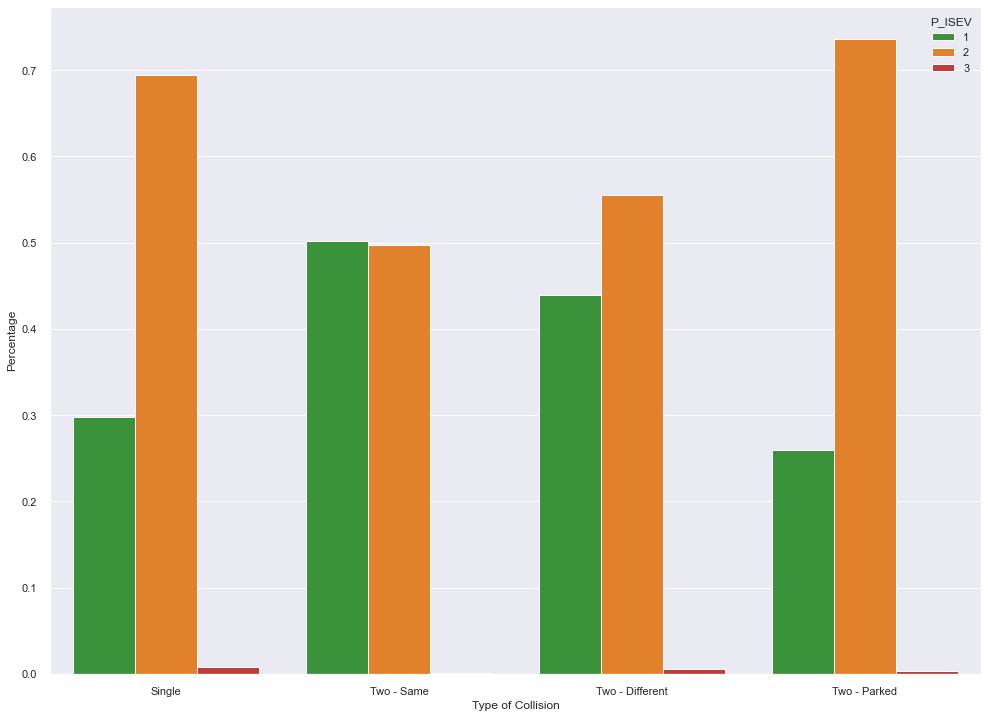

In [58]:
# compare to those with safety equipment, where the percentage of death is almost zero
sns.barplot(data = safety, x = "C_CONFRANGE", y = "percentage", hue="P_ISEV",palette= palette,)
plt.xlabel('Type of Collision')
plt.ylabel('Percentage')

In [59]:
# End

# Additional Graphs Not Used:

[Text(0, 1, 'Single - Hit a moving object'),
 Text(0, 2, 'Single - Hit a stationary object'),
 Text(0, 3, 'Single - Ran off left shoulder'),
 Text(0, 4, 'Single - Ran off right shoulder'),
 Text(0, 5, 'Single - Rollover on roadway'),
 Text(0, 6, 'Single - Any other single vehicle collision config'),
 Text(0, 21, 'Two Same Direction - Rear-end collision'),
 Text(0, 22, 'Two Same Direction - Side swipe'),
 Text(0, 23, 'Two Same Direction - One passing to left of other, or left turn conflict'),
 Text(0, 24, 'Two Same Direction - one passing to right of other, or right turn conflict'),
 Text(0, 25, 'Two Same Direction - Other'),
 Text(0, 31, 'Two Different Direction - Head-on collision'),
 Text(0, 32, 'Two Different Direction - Approaching side-swipe'),
 Text(0, 33, 'Two Different Direction - Left turn across opposing traffic'),
 Text(0, 34, 'Two Different Direction - Right turn, including turning conflicts'),
 Text(0, 35, 'Two Different Direction - Right angle collision'),
 Text(0, 36, 'T

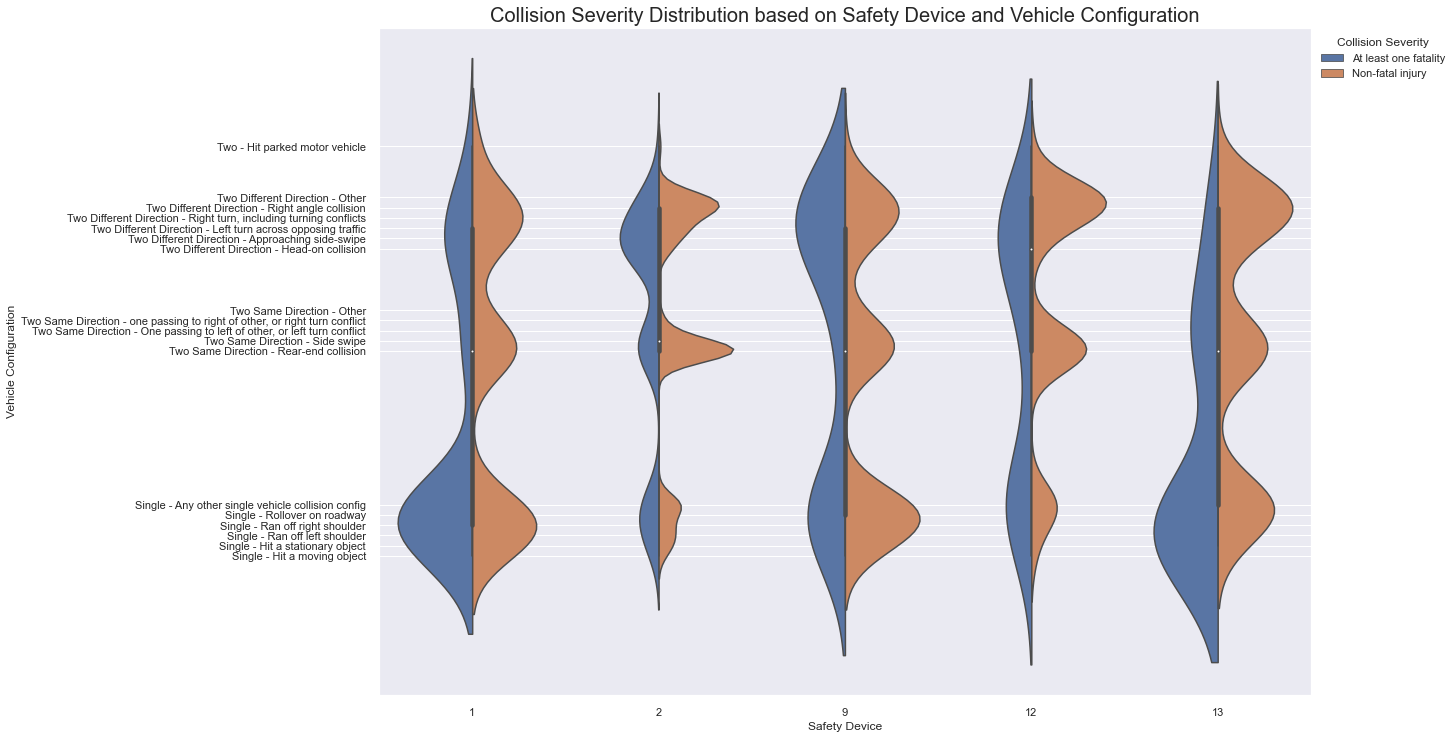

In [60]:
colls_box = sns.violinplot(data=colls1, x="P_SAFE", y="C_CONF", hue="C_SEV", split=True)
labels=['At least one fatality','Non-fatal injury']
h, l = colls_box.get_legend_handles_labels()
colls_box.legend(h, labels, title="Collision Severity")
sns.move_legend(colls_box, "upper left", bbox_to_anchor=(1, 1))
colls_box.set(xlabel="Safety Device",ylabel="Vehicle Configuration")
plt.title('Collision Severity Distribution based on Safety Device and Vehicle Configuration',fontdict={'fontsize': title_fontsize})
colls_box.set_yticks([ 1,  2,  3,  4,  5,  6, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 36, 41])
colls_box.set_yticklabels(['Single - Hit a moving object','Single - Hit a stationary object','Single - Ran off left shoulder','Single - Ran off right shoulder','Single - Rollover on roadway','Single - Any other single vehicle collision config','Two Same Direction - Rear-end collision','Two Same Direction - Side swipe','Two Same Direction - One passing to left of other, or left turn conflict','Two Same Direction - one passing to right of other, or right turn conflict','Two Same Direction - Other','Two Different Direction - Head-on collision','Two Different Direction - Approaching side-swipe','Two Different Direction - Left turn across opposing traffic','Two Different Direction - Right turn, including turning conflicts','Two Different Direction - Right angle collision','Two Different Direction - Other','Two - Hit parked motor vehicle'])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'No safety device used or no child restraint used'),
  Text(1, 0, 'Safety device used or child restraint used'),
  Text(2, 0, 'Helmet worn'),
  Text(3, 0, 'Reflective clothing worn'),
  Text(4, 0, 'Both helmet and reflective clothing worn'),
  Text(5, 0, 'Other safety device used'),
  Text(6, 0, 'No safety deviced used')])

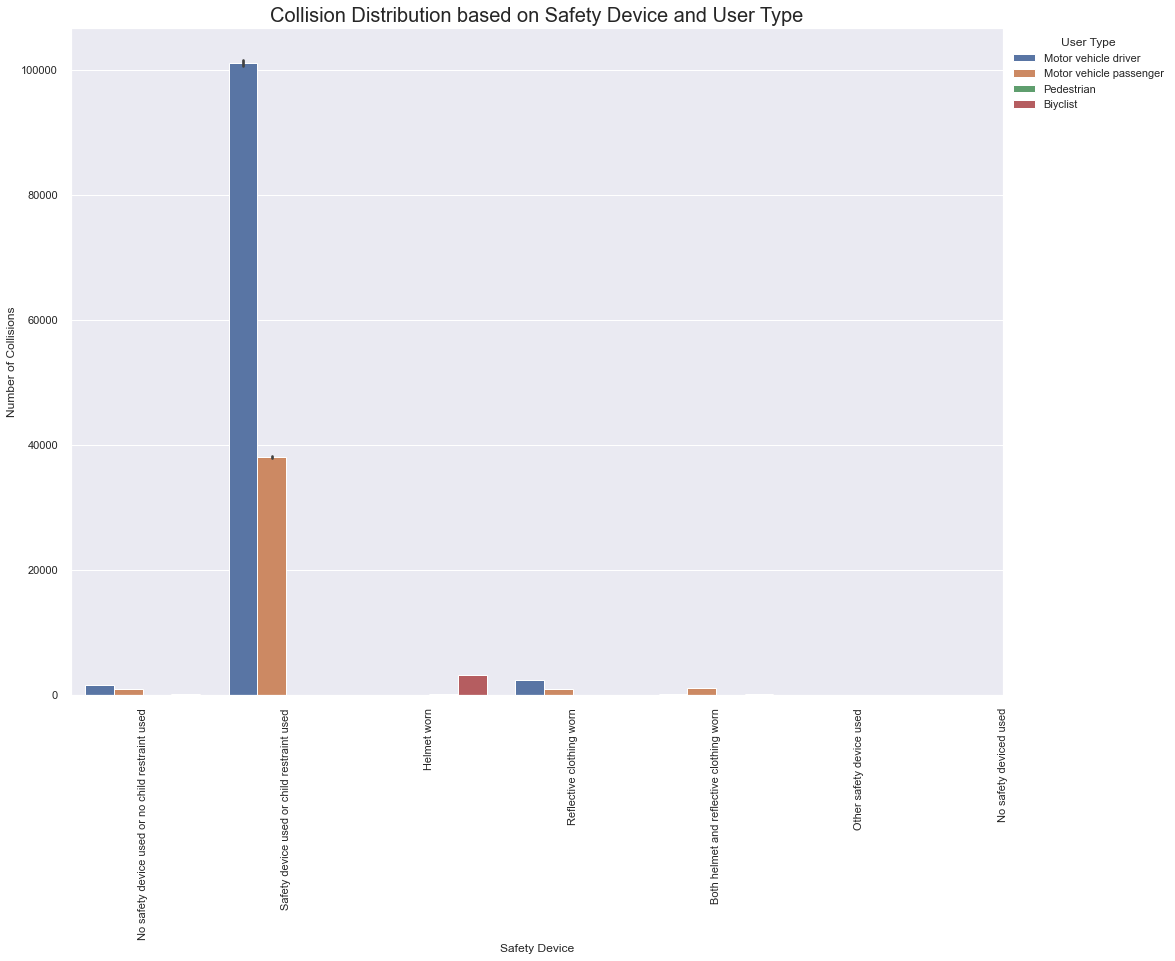

In [61]:
# Analyze collisions based on safety device used and type of user

colls_bar = sns.barplot(data=colls1, x="P_SAFE", y="total_collisions", hue="P_USER", palette="deep", estimator = sum)
labels=['Motor vehicle driver','Motor vehicle passenger','Pedestrian','Biyclist','Motorcyclist']
h, l = colls_bar.get_legend_handles_labels()
colls_bar.legend(h, labels, title="User Type")
sns.move_legend(colls_bar, "upper left", bbox_to_anchor=(1, 1))
colls_bar.set(xlabel="Safety Device",ylabel="Number of Collisions")
plt.title('Collision Distribution based on Safety Device and User Type',fontdict={'fontsize': title_fontsize})
plt.xticks(range(7), ['No safety device used or no child restraint used','Safety device used or child restraint used','Helmet worn','Reflective clothing worn','Both helmet and reflective clothing worn','Other safety device used','No safety deviced used'])
plt.xticks(rotation=90)

TypeError: set_ticks() missing 1 required positional argument: 'ticks'

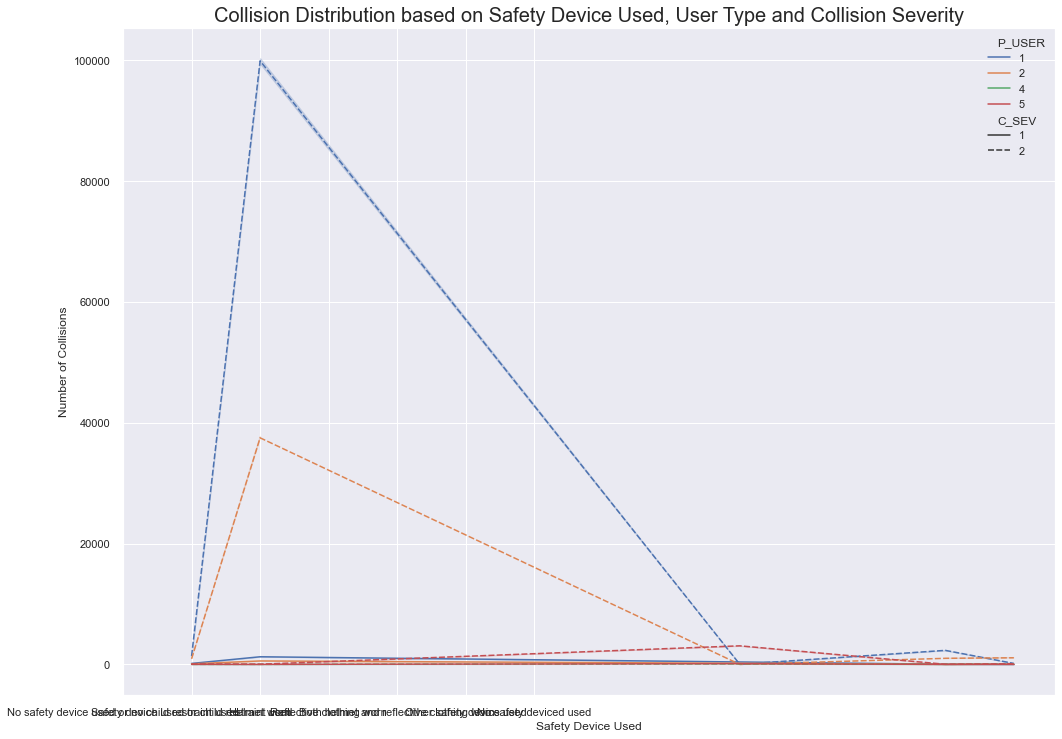

In [62]:
colls_bar = sns.lineplot(data=colls1, x="P_SAFE", y="total_collisions", hue="P_USER", style="C_SEV", palette="deep", estimator = sum)
colls_bar.set(xlabel="Safety Device Used",ylabel="Number of Collisions")
plt.title('Collision Distribution based on Safety Device Used, User Type and Collision Severity',fontdict={'fontsize': title_fontsize})
colls_bar.set_xticks(range(7))
colls_bar.set_xticklabels(['No safety device used or no child restraint used','Safety device used or child restraint used','Helmet worn','Reflective clothing worn','Both helmet and reflective clothing worn','Other safety device used','No safety deviced used'])
colls_bar.set_xticks(rotation=90)